In [1]:
import netCDF4 as nc
import glob
import numpy as np
import time as ti
import matplotlib.pylab as py
from IPython.display import display, clear_output
import numpy.ma as ma
import warnings
warnings.filterwarnings('ignore')
import numpy.ma as ma
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import shapely.geometry as shp
import shapely.ops as ops
from rtree import index
from datetime import datetime
import glob
import matplotlib
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from functools import partial
import pyproj 

import logging
import time as ti
                
from pathlib import Path
import os
import calendar

import sys
sys.path.append('/data/pragallva/2023_repeat_ERA5/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import netcdf_utilities as ncutil
import os
# os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
from tqdm import tqdm
import glob
from PIL import Image
import copy
import itertools
from datetime import date
import temporal_filter_for_all_years_in_one_level_with_seasonal_cycle as tf
import scipy as sc
from scipy.interpolate import interp1d
import hickle as hkl

NH =''
SH ='S'

import matplotlib
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", \
              [ "navy", "dodgerblue", "PowderBlue", "white", "khaki", "orange", "darkred"])

In [2]:
%%time
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
all_blocks_dictionary   = hkl.load(source+'/DELETE_REDUNDANT_BLOCKS.hkl')

CPU times: user 11.9 s, sys: 18.4 s, total: 30.2 s
Wall time: 1min 12s


In [12]:
ls /data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/

BlOCK_TYPES_DIVISION_LWA_based.hkl   DELETE_REDUNDANT_BLOCKS.hkl
BlOCK_TYPES_DIVISION_Z300_based.hkl


In [4]:
# %%time
# source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
# LWA_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_LWA_based.hkl')

# all_blocks_dictionary = LWA_blocks_dictionary

In [5]:
# %%time
# source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
# Z300_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_Z300_based.hkl')

In [6]:
def return_aggregated_bootstrapped_data(regions):    #### Return basically all fields

    std    = []; median = []; mean   = []
    percentile = {str(i): [] for i in range(5, 100, 5)}
    bootstrap_stats = {}
    
    source = '/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/'
    EXTRA = '/BOOTSTRAPPING_BLOCKS/block_evolution_29_days/days4/synoptic_WA_budget/'
    
    for region in regions: 
            lon_region = region.split('_')[0]
            lat_region = region.split('_')[1]
            if os.path.exists('%s/%s/%s/%s/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl'%(source, lon_region, lat_region, EXTRA)):
                
                blocking_details_day_wise = hkl.load('%s/%s/%s/%s/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl'%(source, lon_region, lat_region, EXTRA)) 

                for per in [str(i) for i in range(5, 100, 5)]:
                    percentile[per].append(blocking_details_day_wise['percentile'][per])
                std.append(blocking_details_day_wise['std'])
                mean.append(blocking_details_day_wise['mean'])
                median.append(blocking_details_day_wise['median'])

                
    for key0 in ['mean', 'median', 'std']:
        bootstrap_stats.update( {key0: np.array(eval(key0))} )
        
    bootstrap_stats['percentile']={}
    for per in percentile.keys():
        bootstrap_stats['percentile'][per] = np.array(percentile[per])

    return  bootstrap_stats 


def return_aggregated_data( regions    = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'],\
                            days       = list(np.arange(6,9,1)), \
                            FIELD      = 'u_v_pv_phi', dictionary = {}, \
                            block_type = 'anticyclonic', \
                            total_data_dictionary=None):    #### Return basically all fields
    
        def M1(Y):
            return np.nanmean(Y, axis=1)
        def M0(Y):
            return np.nanmean(Y, axis=0)
        def flatten_set(Y):
            return set(sum((Y), []))
                    
        coord      = hkl.load('/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/lonm60-m0/lat45-60/block_evolution_29_days/days5/u_v_pv_phi/coord_info.hkl')
        lati       = coord['lati']
        loni       = coord['loni']
        
        if block_type in flatten_set([list(total_data_dictionary[region]['days4'][FIELD].keys()) for region in regions]):
            
                relevant_keys = [key for key in total_data_dictionary['lonp0-p60_lat45-60']['days4'][FIELD][block_type].keys() if (key not in ['coord_info'])]
                    
                    ####### FiGURE OUT AN ERROR HERE ###########
                for key in relevant_keys:
                    vars()[key] = []
                persistence = []

                for region in regions: 
                    for day in days:        
                         if 'days%d'%(day) in total_data_dictionary[region].keys():
                            if  block_type in total_data_dictionary[region]['days%d'%(day)][FIELD].keys():

                                relevant_keys = [key for key in total_data_dictionary[region]['days%d'%(day)][FIELD][block_type].keys() \
                                                 if key not in ['coord_info']]
                                for key in relevant_keys:
                                    variable = total_data_dictionary[region]['days%d'%(day)][FIELD][block_type][key]
                                    vars()[key].append(variable)
                                persistence.append(day)

                for key0 in relevant_keys:
                    dictionary.update({ key0: np.vstack(eval(key0)) })

                dictionary['coord']       = {'lati':lati, 'loni':loni}
                dictionary['block_size']  = np.max(days)
                dictionary['persistence'] = persistence
        return  dictionary  
    

In [7]:
dictionary   = return_aggregated_data( regions = ['lonm180-m120_lat45-60', 'lonp120-p180_lat45-60'],\
                            days    = list(np.arange(4,20,1)), \
                            FIELD   = 'synoptic_WA_budget', block_type = 'all_blocks', \
                            dictionary = {}, total_data_dictionary=all_blocks_dictionary)

In [8]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", \
              [ "navy", "dodgerblue", "PowderBlue", "white", "khaki", "orange", "darkred"])

cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "white",  "lightyellow", "peachpuff", "lightgreen", "dodgerblue", "blue", "purple", "brown"])

In [9]:
boostrap_dictionary = return_aggregated_bootstrapped_data(['lonm60-m0_lat45-60'])

In [10]:
dictionary.keys()

dict_keys(['BLOCK_window_list_dAdt_full_synoptic', 'BLOCK_window_list_dxF1_full_synoptic', 'BLOCK_window_list_dxF2_full_synoptic', 'BLOCK_window_list_dxF3_full_synoptic', 'BLOCK_window_list_dxF_full_synoptic', 'BLOCK_window_list_dyEPy_full_synoptic', 'BLOCK_window_list_dzEPz_full_synoptic', 'coord', 'block_size', 'persistence'])

In [11]:
boostrap_dictionary.keys()

dict_keys(['mean', 'median', 'std', 'percentile'])

In [13]:
def return_block_cycle_synoptic(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], days = [8, 9], \
                                phase='Onset', threshold=65, extra_day=3, block_type='anticyclonic', \
                                total_data_dictionary=all_blocks_dictionary, CI=[5,95]):
    
    #### This is for synoptic winter-time wave activity budget with seasonal cycle removed ###
    
    dictionary = return_aggregated_data( regions = regions,\
                                         days    = days, FIELD = 'synoptic_WA_budget', \
                                         dictionary = {}, block_type=block_type, total_data_dictionary=total_data_dictionary) 
    dictionary = return_aggregated_data( regions = regions,\
                                         days    = days, FIELD = 'synoptic_WA_fluxes', \
                                         dictionary =  dictionary, block_type=block_type, total_data_dictionary=total_data_dictionary) 
    dictionary = return_aggregated_data( regions = regions,\
                                         days    = days, FIELD = 'unfiltered_WA_fluxes', \
                                         dictionary =  dictionary, block_type=block_type, total_data_dictionary=total_data_dictionary)
    
    boostrap_dictionary = return_aggregated_bootstrapped_data(regions)
    
    
    day = int(np.mean(days))
    A_unfiltered = dictionary['BLOCK_window_list_A_full_unfiltered']
    peak_time  = (A_unfiltered.shape[1]-1)//2 
    start_time = peak_time - day//2 - extra_day
    end_time   = peak_time + day//2 + extra_day

    if phase   == 'Onset':
        timing  = slice(start_time, peak_time+1)
    elif phase == 'Decay':
        timing  = slice(peak_time, end_time+1)
    else:
        timing  = slice(start_time, end_time+1)
    full_timing   = (np.linspace(-(A_unfiltered.shape[1]-1)/2+0.5, (A_unfiltered.shape[1]-1)/2+0.5, A_unfiltered.shape[1]))

#     print (full_timing)
#     print (full_timing[timing])
    
    def M1(Y):
        X = (Y[:,timing,...])
#       XX = X[:,-1,...]-X[:,0,...]
#       masking = ma.masked_where( A_unfiltered[:,timing,...] < threshold, X) 
        return X

    def M(Y):
        X = (Y[:,peak_time,...])
        return X  
    
    
    A              = M1(dictionary['BLOCK_window_list_A_full_synoptic'])
    F              = M1(dictionary['BLOCK_window_list_F_full_synoptic'])
    F1             = M1(dictionary['BLOCK_window_list_F1_full_synoptic'])
    F2             = M1(dictionary['BLOCK_window_list_F2_full_synoptic'])
    F3             = M1(dictionary['BLOCK_window_list_F3_full_synoptic'])
    F_EPy          = M1(dictionary['BLOCK_window_list_F_EPy_full_synoptic'])
    F_EPz          = M1(dictionary['BLOCK_window_list_F_EPz_full_synoptic'])
    
    
    dA             = M1(dictionary['BLOCK_window_list_dAdt_full_synoptic']);    dA_name         = r'{\langle {\frac{\partial A}{\partial t}} \rangle}'
    dF_dx_dt       = M1(dictionary['BLOCK_window_list_dxF_full_synoptic']);     dF_dx_dt_name   = r'{\langle {-\frac{\partial F} {\partial x}} \rangle}'
    dEPy_dy_dt     = M1(dictionary['BLOCK_window_list_dyEPy_full_synoptic']); dEPy_dy_dt_name = r'{\langle{-\frac{\partial EP_y}{\partial y}} \rangle}'
    dEPz_dz_dt     = M1(dictionary['BLOCK_window_list_dzEPz_full_synoptic']);   dEPz_dz_dt_name = r'{\langle {-\frac{\partial EP_z}{\partial z}} \rangle}'
    
    dF1_dx_dt      = M1(dictionary['BLOCK_window_list_dxF1_full_synoptic']);  dF1_dx_dt_name   = r'{\langle {-\frac{\partial F_1} {\partial x}} \rangle}'
    dF2_dx_dt      = M1(dictionary['BLOCK_window_list_dxF2_full_synoptic']);  dF2_dx_dt_name   = r'{\langle {-\frac{\partial F_2} {\partial x}} \rangle}'
    dF3_dx_dt      = M1(dictionary['BLOCK_window_list_dxF3_full_synoptic']);  dF3_dx_dt_name   = r'{\langle {-\frac{\partial F_3} {\partial x}} \rangle}'

    
    low, high = CI[0], CI[-1]
    
#     print ('dA_dt_low_ci', boostrap_dictionary['percentile'][str(low)].shape)
    dA_dt_low_ci      = M1(boostrap_dictionary['percentile'][str(low)])
    dA_dt_high_ci     = M1(boostrap_dictionary['percentile'][str(high)])
    
#     print ('dA',           dA.shape)
    
    loni, lati    = dictionary['coord']['loni'], dictionary['coord']['lati'] 
       
    residual = dA-(dF_dx_dt+dEPy_dy_dt+dEPz_dz_dt); residual_name   = r'{\langle {residual} \rangle}'
       
    var_strings = {'<dA/dt>':dA_name,            '<-dF/dx>' :dF_dx_dt_name, \
                   '<-dEPy/dy>': dEPy_dy_dt_name,  \
                   '<-dEPz/dz>':dEPz_dz_dt_name, '<-dF1/dx>':dF1_dx_dt_name, \
                   '<-dF2/dx>':dF2_dx_dt_name,   '<-dF3/dx>':dF3_dx_dt_name, 'residual':'residual', \
                   'dA_dt_low_ci': '%s%%'%(low) , 'dA_dt_high_ci': '%s%%'%(high) , }
    
#     var_names = {'<dA/dt>':'LWA tendency',            '<-dF/dx>' :'zonal LWA flux conv.', \
#                    '<-dEPy/dy>': 'eddy momentum flux div.',  \
#                    '<-dEPz/dz>':'sfc eddy heat flux',   '<-dF1/dx>':r'linear advection by $u_{_{REF}}$', \
#                    '<-dF2/dx>':'nonlinear component', '<-dF3/dx>':r'linear advection by $c_g$', 'residual':'residual', \
#                    'dA_dt_low_ci': '%s%%'%(low) , 'dA_dt_high_ci': '%s%%'%(high)}


    var_names = {'<dA/dt>':'LWA tendency',            '<-dF/dx>' :'(I): zonal flux convergence', \
                   '<-dEPy/dy>': '(II): meridional flux convergence', '<-dF_linear/dx>' :'(Ia): linear component', \
                   '<-dEPz/dz>':'(III): surface flux injection',   '<-dF1/dx>':r'(Ia): linear advection by $u_{_{REF}}$', \
                   '<-dF2/dx>':'(Ib): nonlinear component', '<-dF3/dx>':r'(Ic): linear advection by $c_g$', 'residual':'(IV): residual', \
                   'dA_dt_low_ci': '%s%%'%(low) , 'dA_dt_high_ci': '%s%%'%(high), \
                   'F1': 'Zonal advective flux', 'F3':  'Zonal advective flux', \
                   'F2': r'$0.25 \times$ Nonlinear zonal flux', 'F1+F3': r'$0.25 \times$ Linear zonal flux', 'F':'Zonal LWA flux', 'A':'LWA'}

        
#     timing = np.arange(start_time, end_time+1, 1)
#     timing = timing - timing.mean()


    dictionary_phase = {'<dA/dt>':dA, '<-dF/dx>':dF_dx_dt, \
                        '<-dEPy/dy>':dEPy_dy_dt, '<-dEPz/dz>':dEPz_dz_dt, '<-dF_linear/dx>': dF3_dx_dt+dF1_dx_dt, \
                        '<-dF1/dx>': dF1_dx_dt, '<-dF2/dx>':dF2_dx_dt, '<-dF3/dx>': dF3_dx_dt, \
                        'loni': loni, 'lati':lati, 'phase': phase, 'timing':full_timing[timing], 'residual':residual, \
                         'no_of_events':dictionary['BLOCK_window_list_A_full_synoptic'].shape[0], \
                         'A': A, 'F':F, 'F1':F1, 'F2':F2,  'F3':F3, 'F_EPy':F_EPy, 'F_EPz':F_EPz, \
                         'var_strings':var_strings, 'var_names': var_names, \
                         'persistence':dictionary['persistence'], \
                         'dA_dt_low_ci': dA_dt_low_ci , 'dA_dt_high_ci': dA_dt_high_ci}
        
    return dictionary_phase 



In [14]:
def make_latex(Y):
    return Y ## '$'+Y+'$'

def return_mean_std(key = 'dA', dictionary_phase3=dictionary, position='center', lon_edge=20):
   
    central_lon = dictionary_phase3[key].shape[-1]//2
    central_lat = dictionary_phase3[key].shape[-2]//2

#     print (key, dictionary_phase3[key].shape)
    
    if position == 'center':
        std  = np.nanstd(((dictionary_phase3[key][:, :, central_lat,central_lon])), axis=0)/2  ##### [:, 31//2,121//2]/2
        mean = dictionary_phase3[key][:,:, central_lat,central_lon].mean(axis=0)
        events = dictionary_phase3[key][:,:, central_lat,central_lon]
    if position == 'western':
        std  = np.nanstd(((dictionary_phase3[key][:, :, central_lat, central_lon-lon_edge])), axis=0)/2  ##### [:, 31//2,121//2]/2
        mean = dictionary_phase3[key][:,:, central_lat, central_lon-lon_edge].mean(axis=0)
        events = dictionary_phase3[key][:,:, central_lat,central_lon-lon_edge]
    if position == 'eastern':
        std  = np.nanstd(((dictionary_phase3[key][:, :, central_lat, central_lon+lon_edge])), axis=0)/2  ##### [:, 31//2,121//2]/2
        mean = dictionary_phase3[key][:,:, central_lat, central_lon+lon_edge].mean(axis=0)
        events = dictionary_phase3[key][:,:, central_lat,central_lon+lon_edge]
        
    mini  = mean-std
    maxi  = mean+std
    dicti = dict(mean=mean, mini=mini, maxi=maxi, event=events, std=std)
    return dicti


def plot_lifecycle(key='dA', co='k', STD=False, dictionary_phase3=dictionary,  \
                   lw=4, position='center', lon_edge=20, ax=None, FONTSIZE=20, \
                   ALPHA=1, linestyle='-', each_event=False, thin_lw=1,):
    
    if ax is None:
        ax = py
    dicti = return_mean_std(key = key, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    
    if each_event:
        for n in range(dicti['event'].shape[0]):
            ax.plot(dictionary_phase3['timing'], dicti['event'][n,...], '-', lw=thin_lw, color=co, alpha=0.1)
    if STD:
        mini = return_mean_std(key = 'dA_dt_low_ci', dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
        maxi = return_mean_std(key = 'dA_dt_high_ci', dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
        ax.fill_between(dictionary_phase3['timing'], mini['mean'], maxi['mean'], color=co, alpha=0.1)
        
    else:
        ax.plot(dictionary_phase3['timing'], dicti['mean'], linestyle, lw=lw, label = make_latex(dictionary_phase3['var_names'][key]), color=co, alpha=ALPHA)
#         ax.errorbar(dictionary_phase3['timing'], dicti['mean'], yerr=dicti['std'],\
#             ecolor=co, ls='', alpha=alpha, color=color)




def plot_lifecycle_sum(key1='dA', key2='dA', co='k', STD=False, dictionary_phase3=dictionary, lw=4, position='center', \
                       lon_edge=20, ax=None, FONTSIZE=20, ALPHA=1, linestyle='-',  each_event=False, thin_lw=1):
    if ax is None:
        ax = py  
    dicti1 = return_mean_std(key = key1, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    dicti2 = return_mean_std(key = key2, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    
    if each_event:
        for n in range(dicti1['event'].shape[0]):
            ax.plot(dictionary_phase3['timing'], dicti1['event'][n,...]+dicti2['event'][n,...], linestyle, lw=thin_lw, color=co, alpha=0.1)

    if STD:
        ax.fill_between(dictionary_phase3['timing'], dicti1['mini'], dicti1['maxi'], color=co, alpha=0.1)
    else:
        ax.plot(dictionary_phase3['timing'], dicti1['mean']+dicti2['mean'], '-', lw=lw, \
                label = make_latex(dictionary_phase3['var_names']['F1+F3']), color=co, alpha=ALPHA)
        
        


def plot_all(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
             days = [4,5,6,7,8,9,10,11,12,13,14,15,16,17], phase='all', position='center', \
             lon_edge=20, ax=None, FONTSIZE=20, ALPHA=1, extra_day=3, block_type='anticyclonic', YLIM = 0.00025, each_event=False,\
             total_data_dictionary=all_blocks_dictionary, CI=[5, 95]):
    
    dictionary_phase3 =  return_block_cycle_synoptic(regions = regions, days = days, phase=phase,  extra_day=extra_day, block_type=block_type, total_data_dictionary=total_data_dictionary, CI=CI) 
    
    plot_lifecycle(key='<dA/dt>',     co='k',       dictionary_phase3=dictionary_phase3,          lw=10, position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)
    plot_lifecycle(key='<-dF/dx>',    co='crimson', dictionary_phase3=dictionary_phase3,    lw=8,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=False, linestyle='--',)
    plot_lifecycle(key='<-dEPy/dy>',  co='b',       dictionary_phase3=dictionary_phase3,          lw=8,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.6, each_event=False)
    plot_lifecycle(key='<-dEPz/dz>',  co='orange',  dictionary_phase3=dictionary_phase3,     lw=8,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.6, each_event=False)
    plot_lifecycle(key='residual',    co='gray',    dictionary_phase3=dictionary_phase3, lw=8,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=False)
    plot_lifecycle(key='dA_dt_low_ci',    co='k',   dictionary_phase3=dictionary_phase3,      lw=8,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.5, each_event=False, STD=True)

    
    no_of_events = dictionary_phase3['no_of_events']   
   
    ax.tick_params(labelsize=FONTSIZE)
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    ax.set_ylim(-YLIM, YLIM)

    return no_of_events


def plot_F_decomposed(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
             days = [4,5,6,7,8,9,10,11,12,13,14,15,16,17], phase='all', position='center', \
                    lon_edge=20, ax=None, FONTSIZE=30, extra_day=3, block_type='anticyclonic', YLIM = 0.00025, each_event=False, \
                     total_data_dictionary=all_blocks_dictionary, CI=[5, 95]):
    
    dictionary_phase3 =  return_block_cycle_synoptic(regions = regions, days = days, phase=phase,  extra_day=extra_day, block_type=block_type, total_data_dictionary=total_data_dictionary, CI=CI) 
    
#     plot_lifecycle(key='<dA/dt>',                         co='k',     lw=8, dictionary_phase3=dictionary_phase3,  position=position, lon_edge=lon_edge, ax=ax)
    plot_lifecycle(key='<-dF/dx>',                        co='crimson',   lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge,  ax=ax, FONTSIZE=FONTSIZE,  ALPHA=1,   linestyle='--', each_event=each_event)
    plot_lifecycle(key='<-dF_linear/dx>',                 co='darkmagenta',    lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge,  ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.7, linestyle='-',  each_event=each_event)
    plot_lifecycle(key='<-dF2/dx>',                       co='darkred',   lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge,  ax=ax, FONTSIZE=FONTSIZE,  ALPHA=1, linestyle='-',  each_event=each_event)

#     plot_lifecycle_sum(key1='<-dF3/dx>',key2='<-dF1/dx>', co='dodgerblue',     lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge,  ax=ax, FONTSIZE=FONTSIZE, ALPHA=1, linestyle='--', each_event=each_event)

    plot_lifecycle(key='dA_dt_low_ci',    co='k', dictionary_phase3=dictionary_phase3,   lw=5,  position=position,   lon_edge=lon_edge,   ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.5, each_event=False, STD=True)

    no_of_events = dictionary_phase3['no_of_events']
    
    ax.tick_params(labelsize=FONTSIZE)
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    ax.set_ylim(-YLIM, YLIM)
    
    return no_of_events


def plot_F_decomposed_fluxes(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
             days = [4,5,6,7,8,9,10,11,12,13,14,15,16,17], phase='all', position='center', \
             lon_edge=20, FONTSIZE=20, extra_day=3, block_type='anticyclonic', YLIM = 0.00025, each_event=False, \
             total_data_dictionary=all_blocks_dictionary, ax=None):
    
    
    if ax is None:
        ax = py
    dictionary_phase3 =  return_block_cycle_synoptic(regions = regions, days = days, phase=phase, extra_day=extra_day, block_type=block_type, total_data_dictionary=total_data_dictionary) 
#     print (dictionary_phase3.keys())
     
    plot_lifecycle(key='F',                        co='k', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)    
#     plot_lifecycle(key='F1',                       co='r', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)
    plot_lifecycle(key='F2',                       co='r', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)
#     plot_lifecycle(key='F3',                       co='orange', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)

    plot_lifecycle_sum(key1='F1', key2='F3',       co='b', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)
#   ax.legend(bbox_to_anchor=(1,1), fontsize=FONTSIZE)
    ax.set_ylim(-850, 850)
#     ax1 = ax.twinx()
#     plot_lifecycle(key='A',                        co='k', dictionary_phase3=dictionary_phase3, lw=8, \
#                    position=position, lon_edge=lon_edge, ax=ax1)
#     ax1.tick_params(labelsize=FONTSIZE)

    no_of_events = dictionary_phase3['no_of_events']
    ax.legend(bbox_to_anchor=(1,1), ncol=2)
    ax.tick_params(labelsize=FONTSIZE)
    
    ax.axvline(0, color='gray')

    return no_of_events
   

In [15]:
def plot_lifecycle_for_different_regions(N=0, regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
                                         region_name  = 'North Atlantic sector', days=np.arange(4,18,1), \
                                         FONTSIZE = 30, axs=None, fig=None, block_type='anticyclonic', YLIM= 0.00025, each_event=False, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[5,95], bbox_to_anchor=(0, -1), bbox_to_anchor2=(0.8, -0.55)):
    
    if axs is None:
        fig, axs = py.subplots(2, 2, figsize=(26,18), constrained_layout=True, sharey=True)

    if (len(axs.shape) > 1): 
        AX = axs[N,0]
        
    else:
        AX = axs[0]
    no_of_events = plot_all(regions = regions, \
                            days = days, phase='all', ax=AX, FONTSIZE=FONTSIZE, \
                            block_type=block_type, YLIM=YLIM, each_event=each_event, \
                            total_data_dictionary=total_data_dictionary, CI=CI)
    
    AX.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False, bbox_to_anchor=bbox_to_anchor)
    AX.set_xlabel('days', fontsize=FONTSIZE+2)


    AX.set_xlim(-7.5,7.5)
    
    if (len(axs.shape) > 1): 
        AX = axs[N,1]
    else:
        AX = axs[1]
    no_of_events = plot_F_decomposed(regions = regions, \
                                     days = days, phase='all', ax=AX, FONTSIZE=FONTSIZE, block_type=block_type, YLIM=YLIM, each_event=each_event, \
                                     total_data_dictionary=total_data_dictionary, CI=CI)
    
    AX.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False, bbox_to_anchor=bbox_to_anchor2)
    AX.set_xlabel('days', fontsize=FONTSIZE+2)
    AX.set_xlim(-7.5,7.5)
    
    if ((len(axs.shape) > 1)):
        if N==0:
            axs[N,0].set_title('LWA budget', fontsize=FONTSIZE+5,  y=1.01)
            axs[N,1].set_title('Decomposed zonal flux convergence', fontsize=FONTSIZE+5, y=1.01)
    else:
        axs[0].set_title('LWA budget', fontsize=FONTSIZE+5, y=1.01)
        axs[1].set_title('Decomposed zonal flux convergence', fontsize=FONTSIZE+5, y=1.01)  
        
    return no_of_events

# REGIONS_VARIABLE_NAMES = {'Global composites':      list(LWA_based_block_type_dictionary.keys()), \
#                           'North Atlantic sector':  ['lonm60-m0_lat45-60',    'lonp0-p60_lat45-60', 'lonm60-m0_lat20-30', 'lonm60-m0_lat30-45', 'lonm60-m0_lat60-75', 'lonp0-p60_lat30-45',], \
#                           'North Pacific sector':   ['lonm180-m120_lat45-60', 'lonm180-m120_lat20-30', 'lonm180-m120_lat30-45', 'lonp120-p180_lat45-60', 'lonp120-p180_lat60-75'], \
#                           'North American cluster': ['lonp60-p120_lat45-60'], \
#                           'European cluster':       ['lonm120-m60_lat45-60'], \
#                           'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60']  }
 
    
REGIONS_VARIABLE_NAMES = {'Global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60'],\
                          'Atlantic jet exit':      [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region))], \
                          'Pacific jet exit':       [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region))]}


In [16]:
def plot_lifecycle_fluxes_for_different_regions(N=0, regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
                                         region_name  = 'North Atlantic sector', days=np.arange(4,18,1), \
                                         FONTSIZE = 30, axs=None, fig=None, block_type='anticyclonic', YLIM= 0.00025, each_event=False, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[5,95], bbox_to_anchor=(0, -1), bbox_to_anchor2=(0.8, -0.55)):
    
    if axs is None:
        fig, axs = py.subplots(2, 2, figsize=(26,18), constrained_layout=True, sharey=True)

    if (len(axs.shape) > 1): 
        AX = axs[N,0]
        
    else:
        AX = axs[N]
    
    no_of_events = plot_F_decomposed_fluxes(regions = regions, \
                                 days = days, phase='all', ax=AX, FONTSIZE=FONTSIZE, \
                                 lon_edge=20, extra_day=3, block_type=block_type, YLIM=YLIM, each_event=each_event, \
                                 total_data_dictionary=total_data_dictionary)
        

    AX.legend(bbox_to_anchor=(1,1), ncol=2)
    AX.tick_params(labelsize=FONTSIZE)
    AX.axvline(0, color='gray')
    AX.axhline(0, color='gray')
    
    AX.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False, bbox_to_anchor=bbox_to_anchor)
    AX.set_xlabel('days', fontsize=FONTSIZE+2)


    return no_of_events
    
#     AX.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False, bbox_to_anchor=bbox_to_anchor)
#     AX.set_xlabel('days', fontsize=FONTSIZE+2)

#     AX.set_xlim(-8,8)
    
#     if (len(axs.shape) > 1): 
#         AX = axs[N,1]
#     else:
#         AX = axs[1]
#     no_of_events = plot_F_decomposed(regions = regions, \
#                                      days = days, phase='all', ax=AX, FONTSIZE=FONTSIZE, block_type=block_type, YLIM=YLIM, each_event=each_event, \
#                                      total_data_dictionary=total_data_dictionary, CI=CI)
    
#     AX.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False, bbox_to_anchor=bbox_to_anchor2)
#     AX.set_xlabel('days', fontsize=FONTSIZE+2)
#     AX.set_xlim(-8,8)
    
#     if ((len(axs.shape) > 1)):
#         if N==0:
#             axs[N,0].set_title('LWA budget', fontsize=FONTSIZE+5,  y=1.01)
#             axs[N,1].set_title('Decomposed zonal flux convergence', fontsize=FONTSIZE+5, y=1.01)
#     else:
#         axs[0].set_title('LWA budget', fontsize=FONTSIZE+5, y=1.01)
#         axs[1].set_title('Decomposed zonal flux convergence', fontsize=FONTSIZE+5, y=1.01)  
        
#     return no_of_events
 
    
REGIONS_VARIABLE_NAMES = {'Global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60'],\
                          'Atlantic jet exit':      [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region))], \
                          'Pacific jet exit':       [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region))]}


471


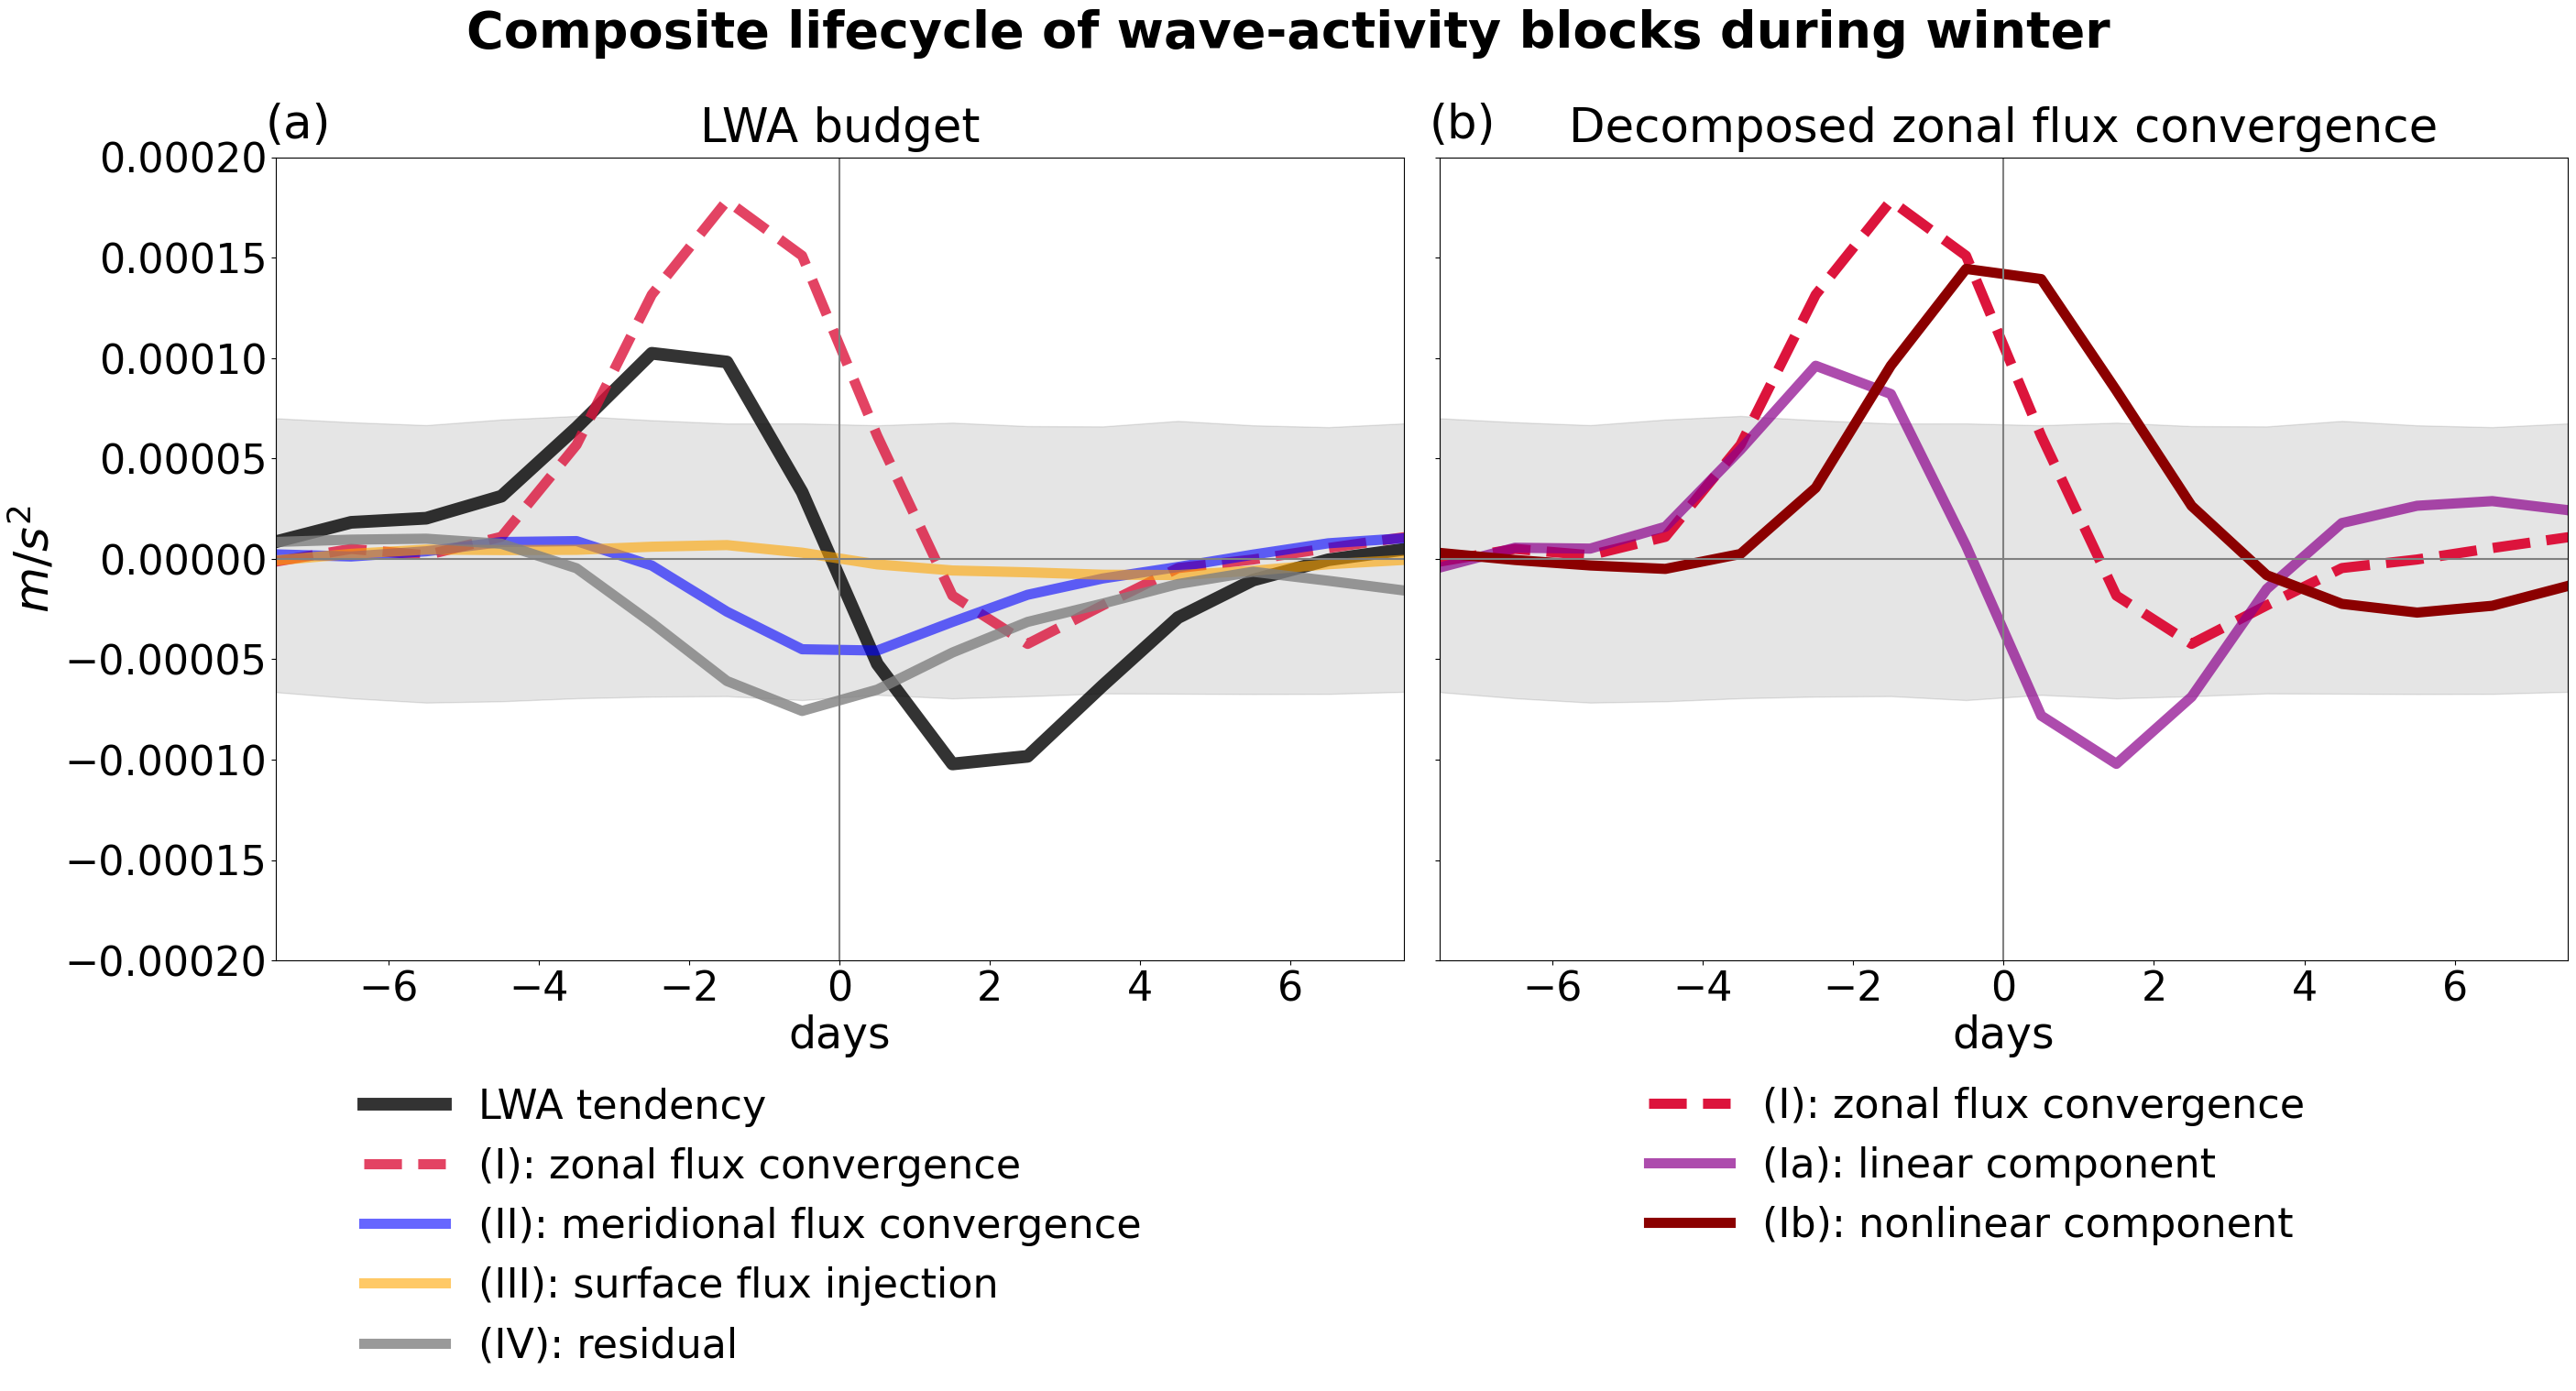

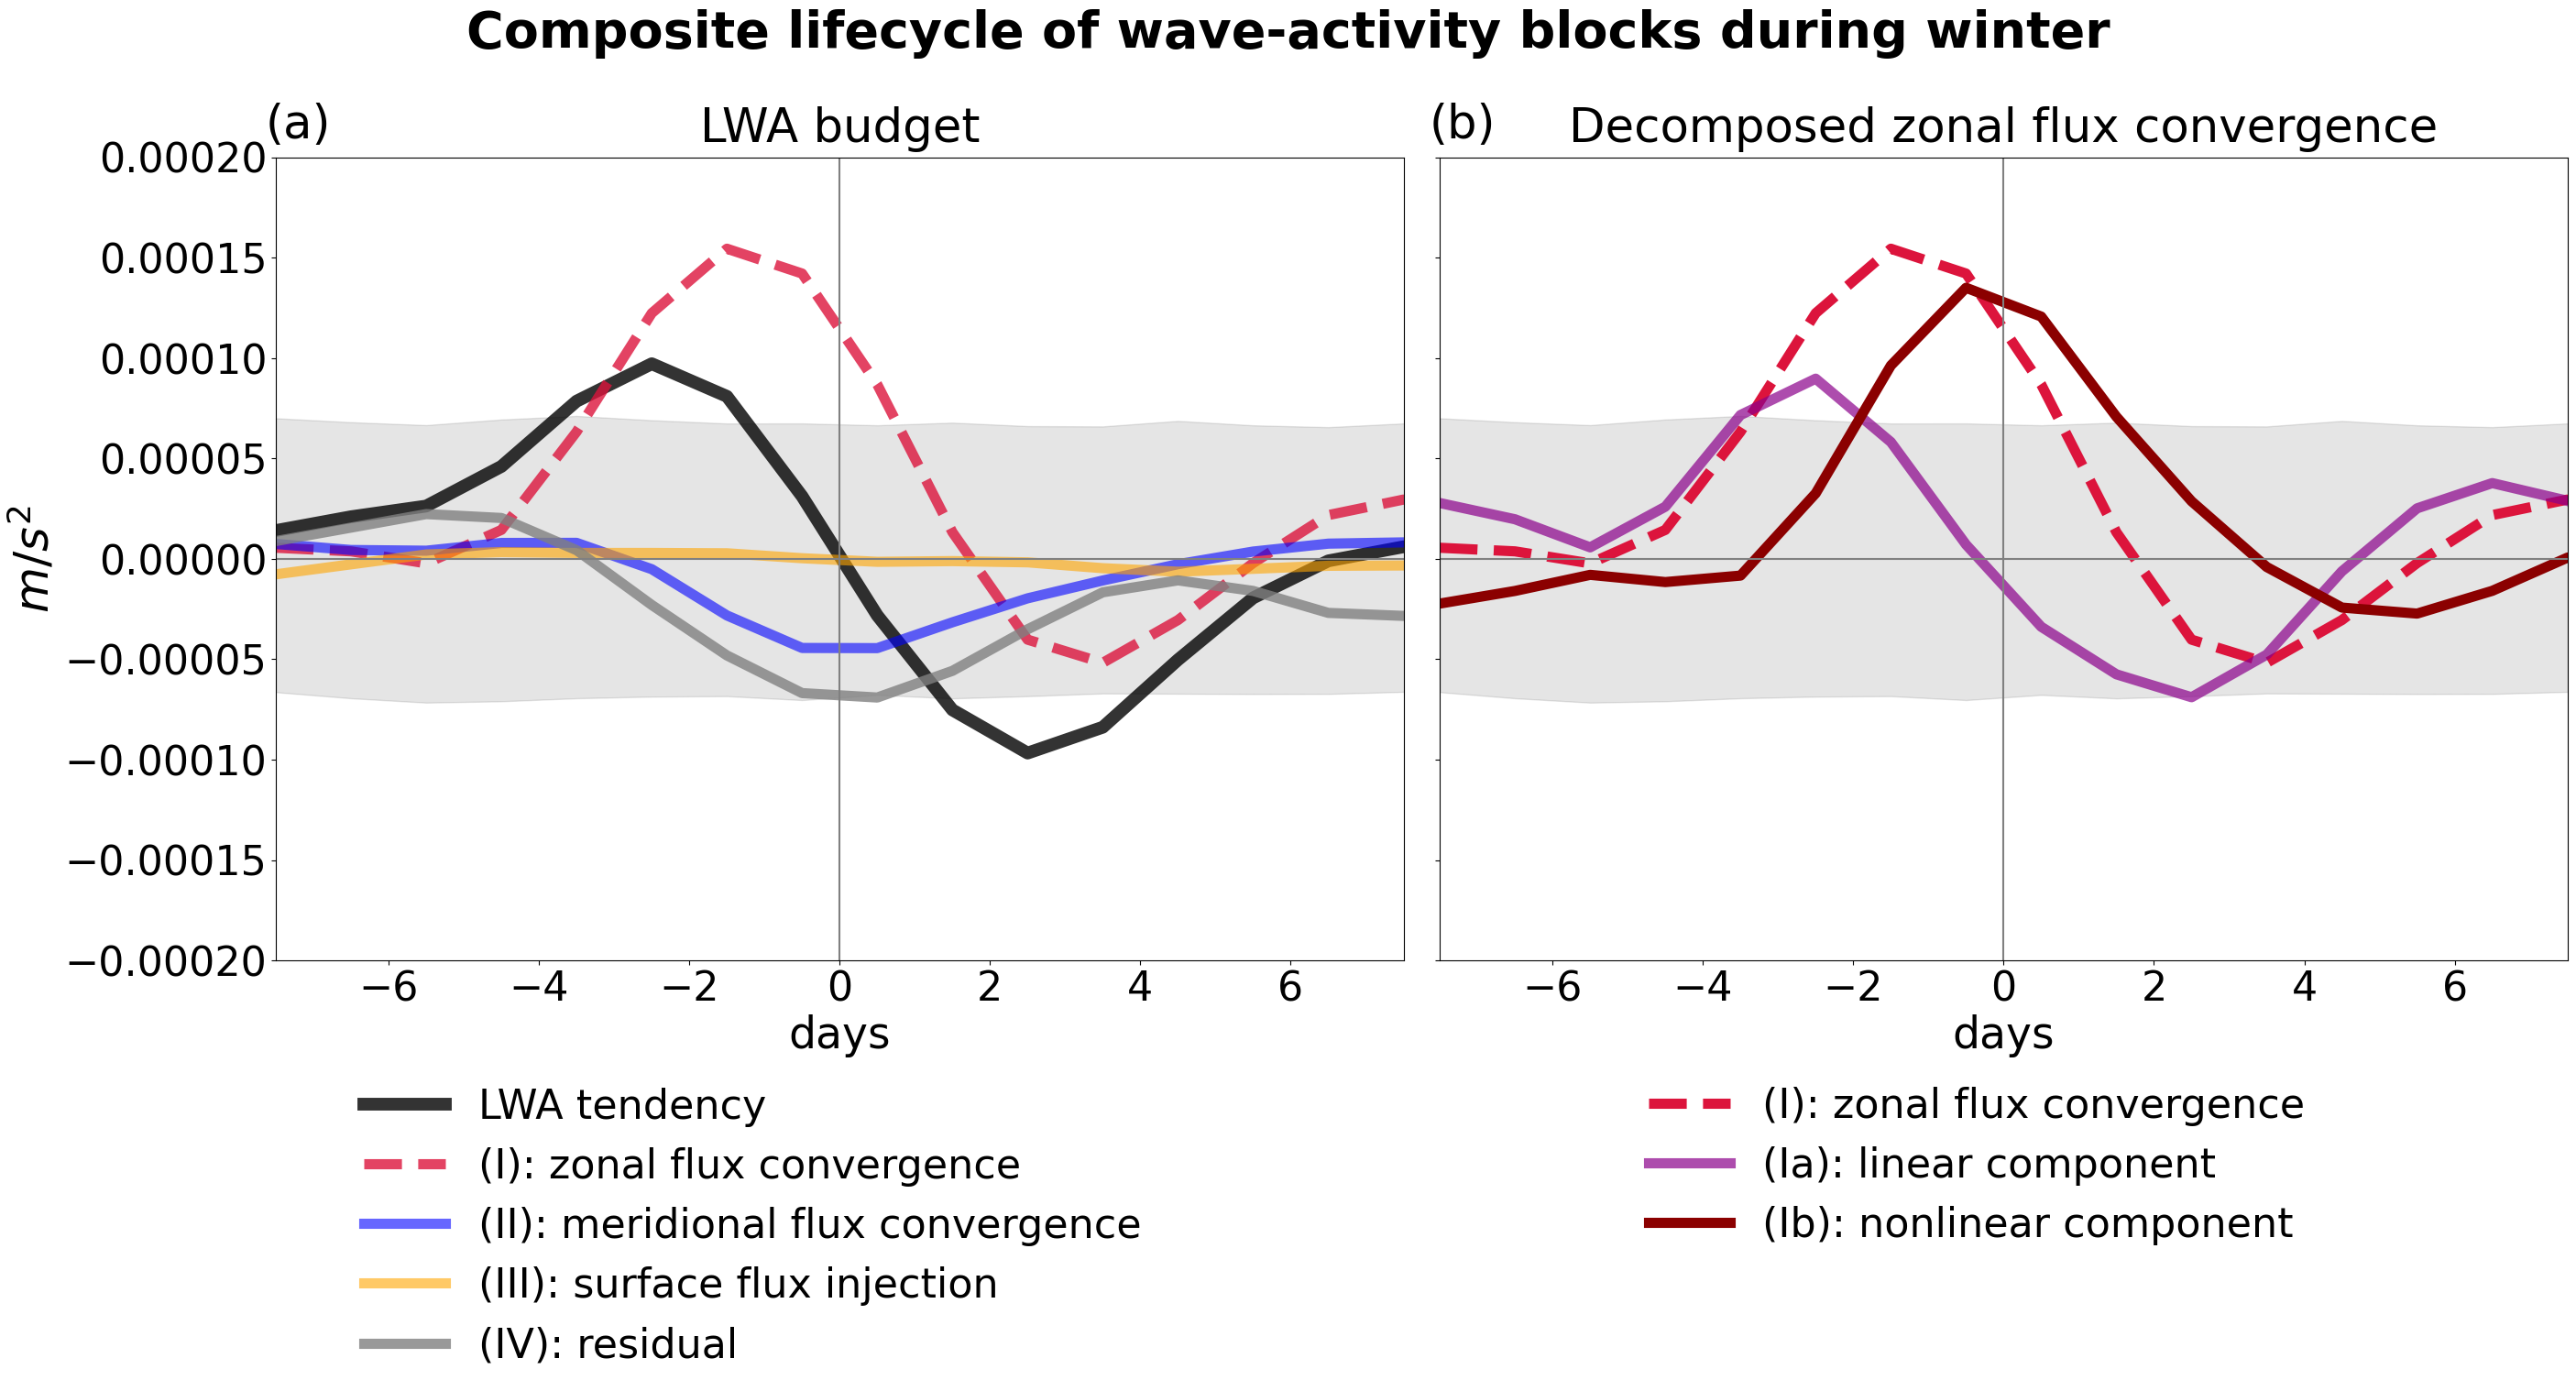

In [134]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of wave-activity blocks during winter', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)

for ax, label in zip(axs, ['(a)', '(b)']):
        ax.text(0.02, 1.04, label,  horizontalalignment='center', verticalalignment='center', \
            transform = ax.transAxes, fontsize=FONTSIZE+5)
    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_global_all_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_global_all_4-18.pdf', bbox_inches='tight')


print (no_of_events)

########## 5-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(5,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of wave-activity blocks during winter', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
for ax, label in zip(axs, ['(a)', '(b)']):
        ax.text(0.02, 1.04, label,  horizontalalignment='center', verticalalignment='center', \
            transform = ax.transAxes, fontsize=FONTSIZE+5)
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_global_all_5-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_global_all_5-18.pdf', bbox_inches='tight')


471
175
62


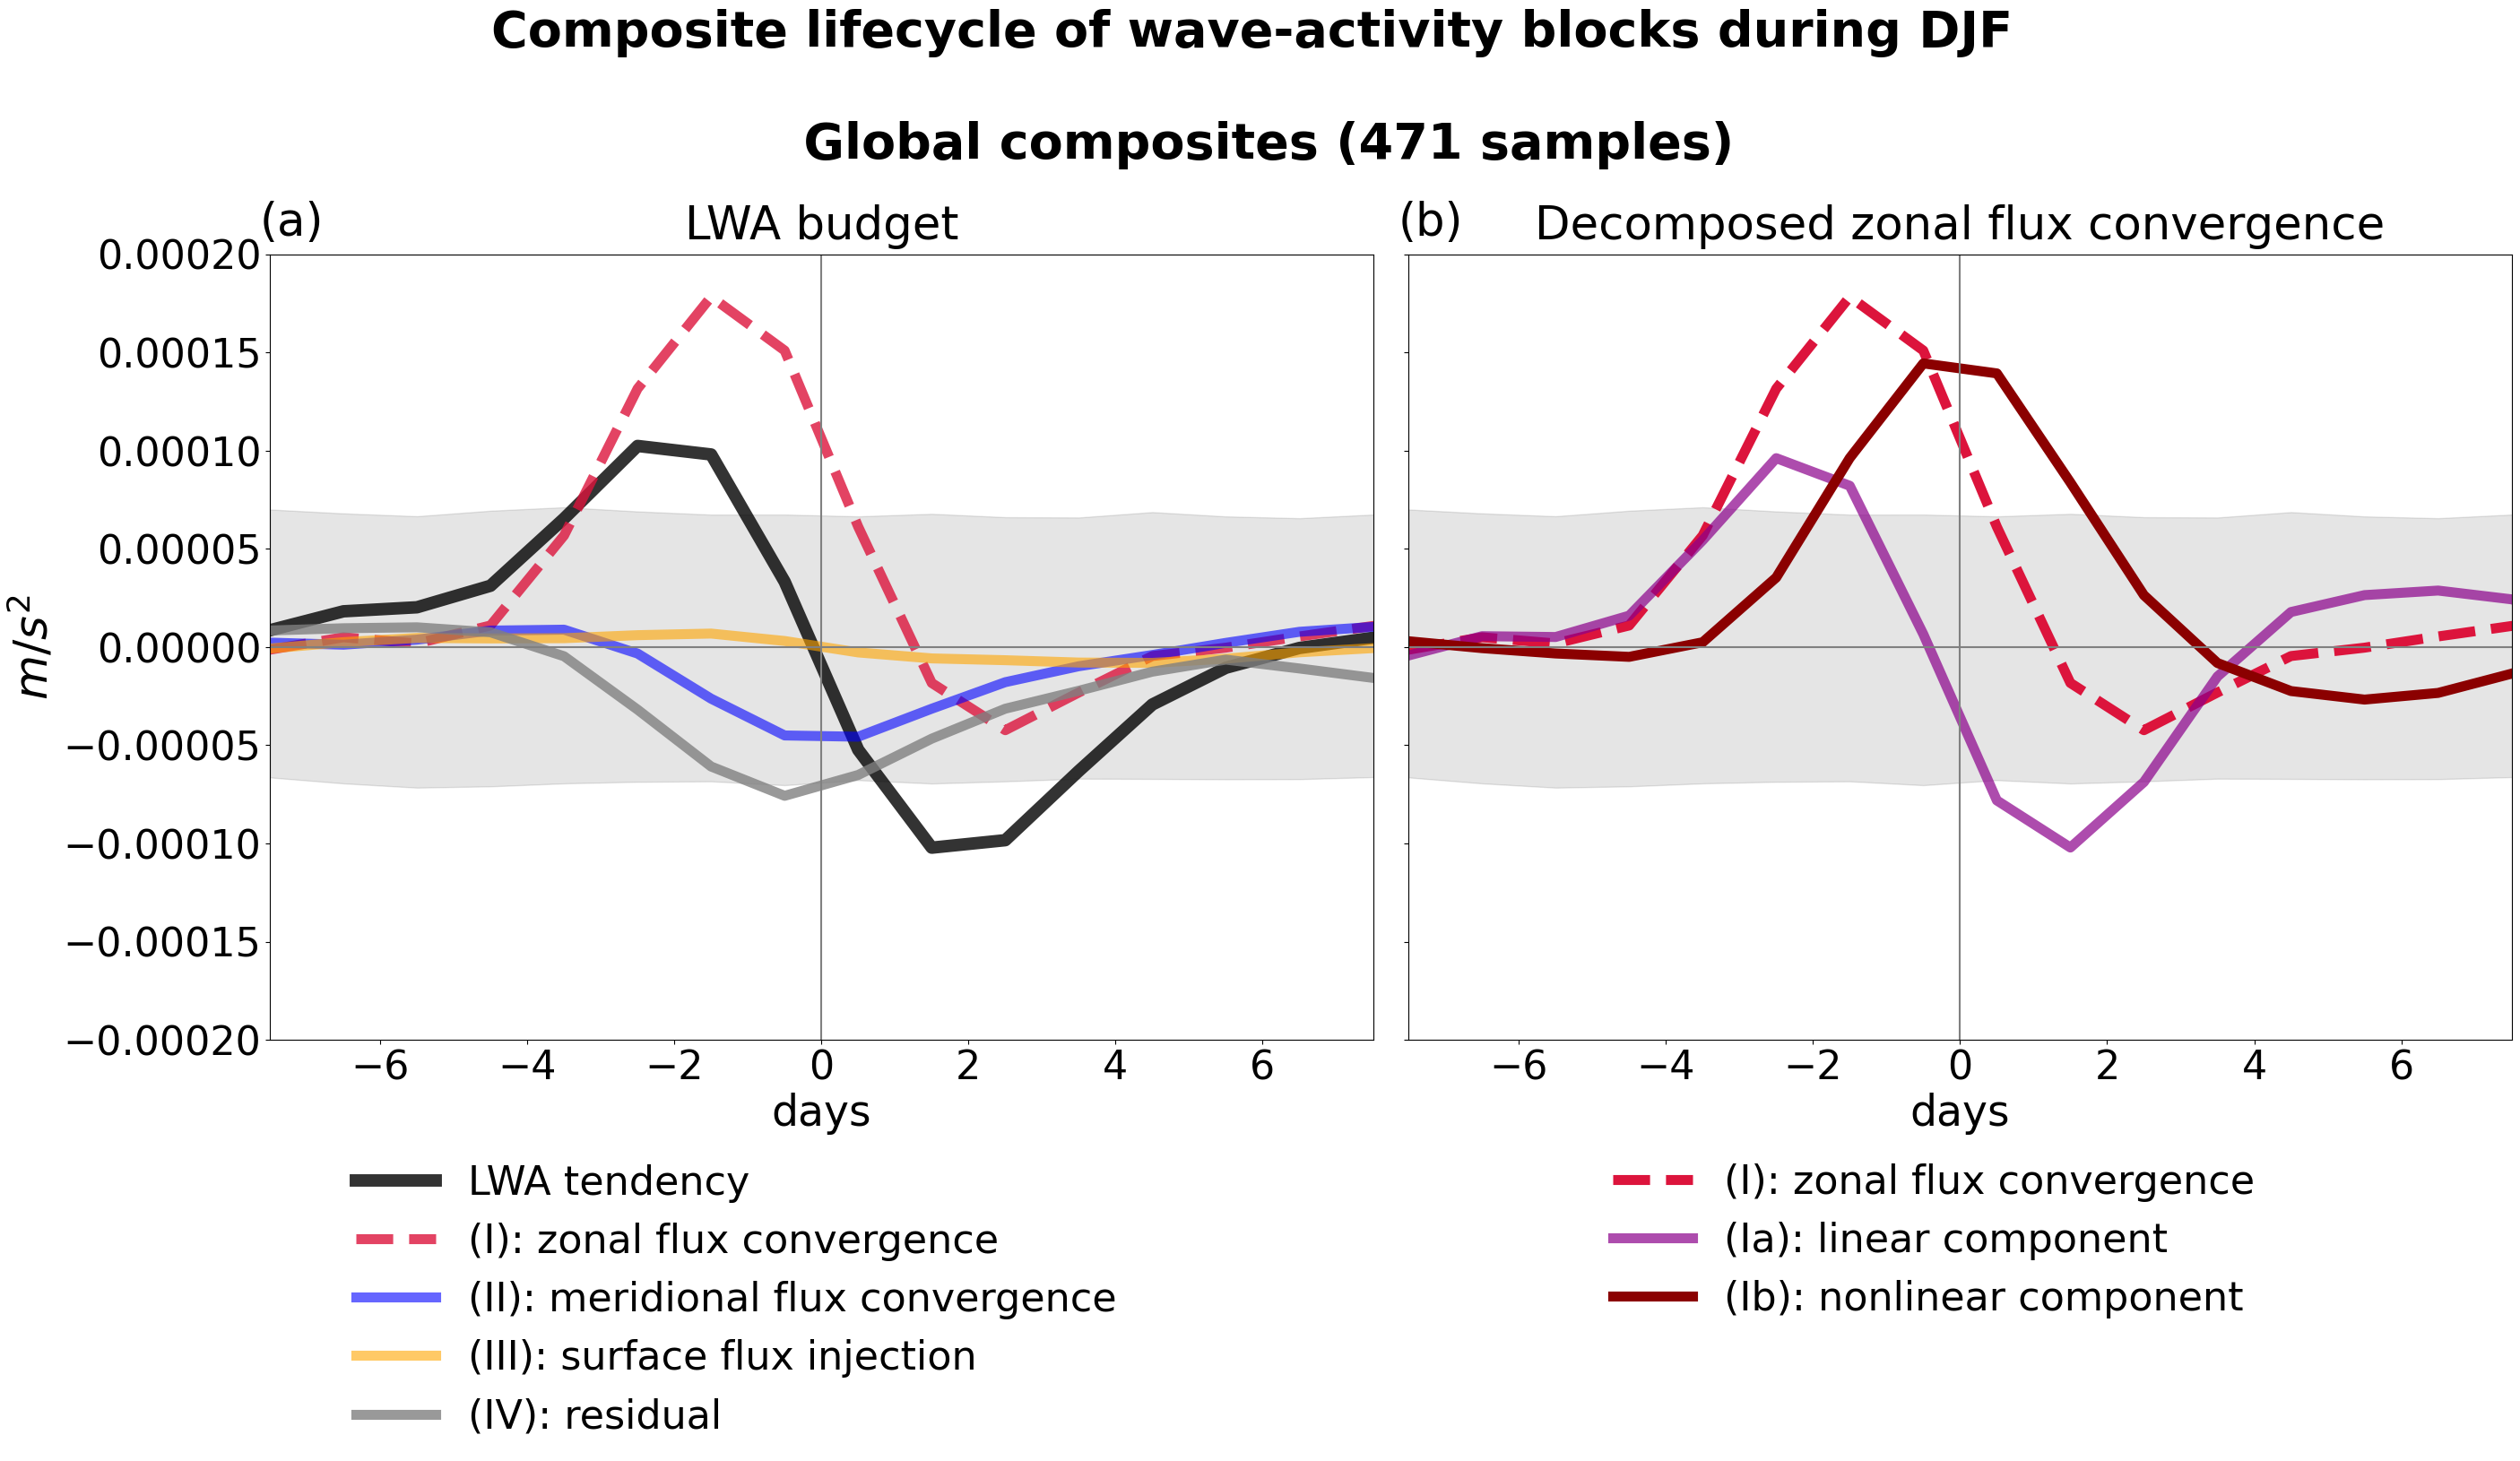

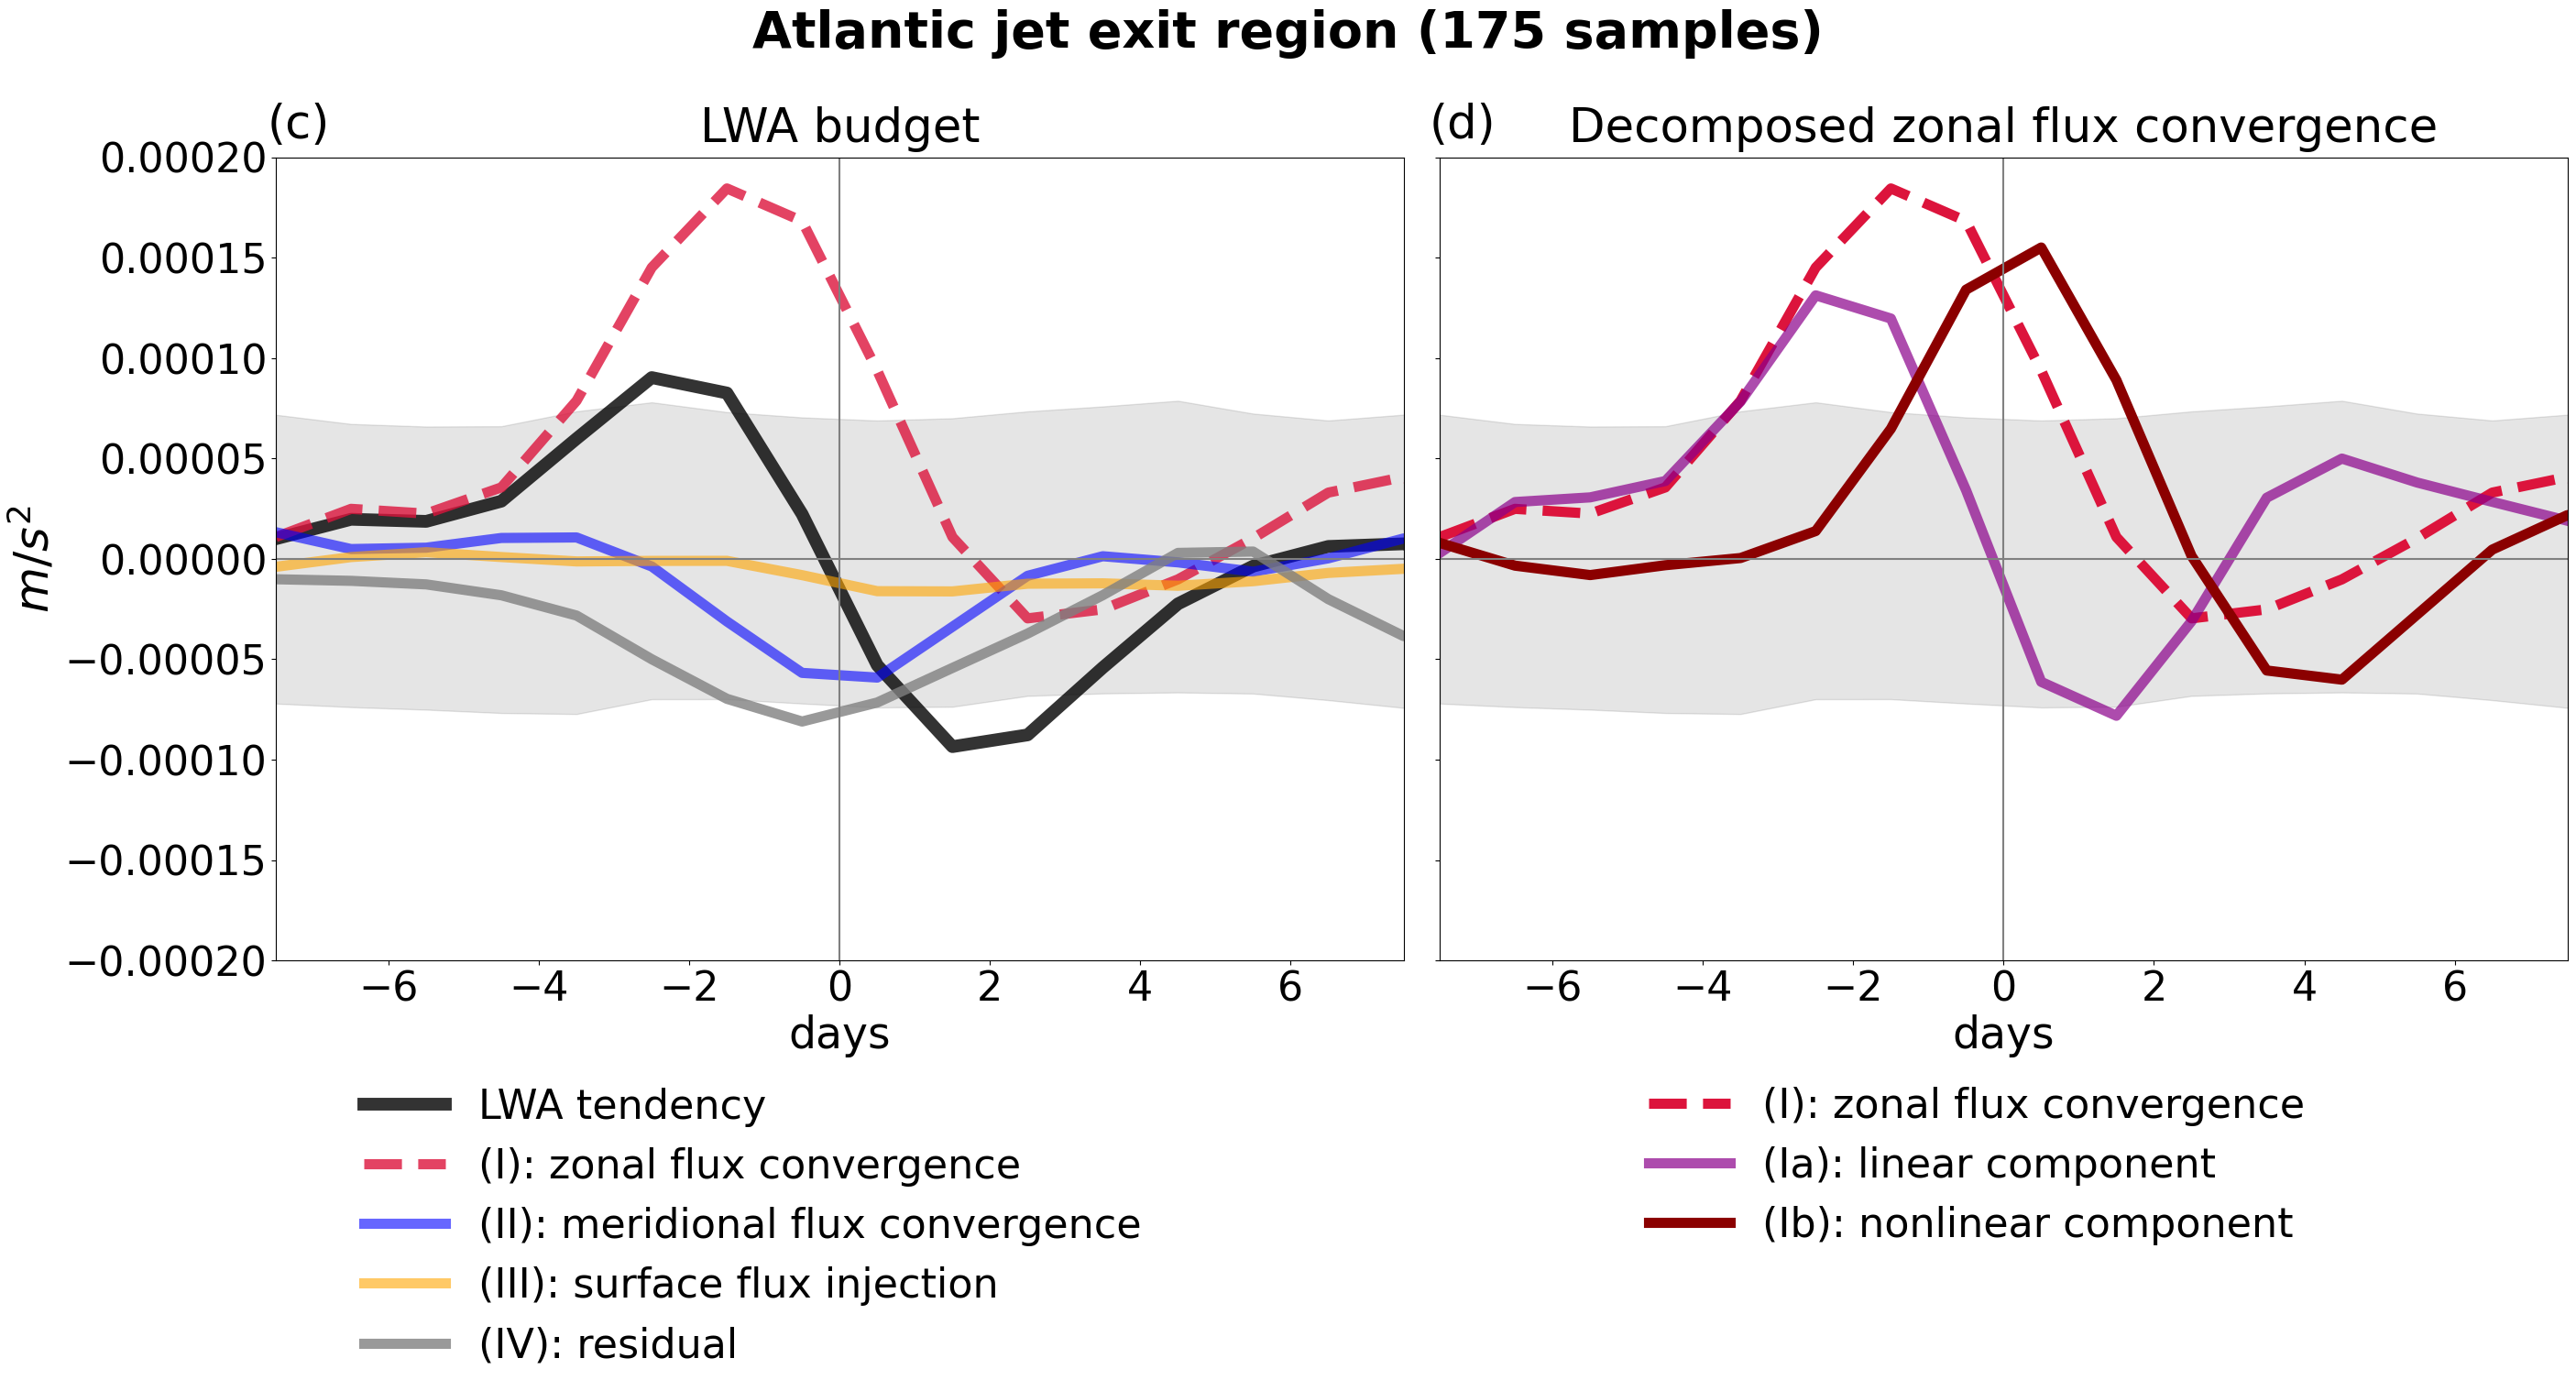

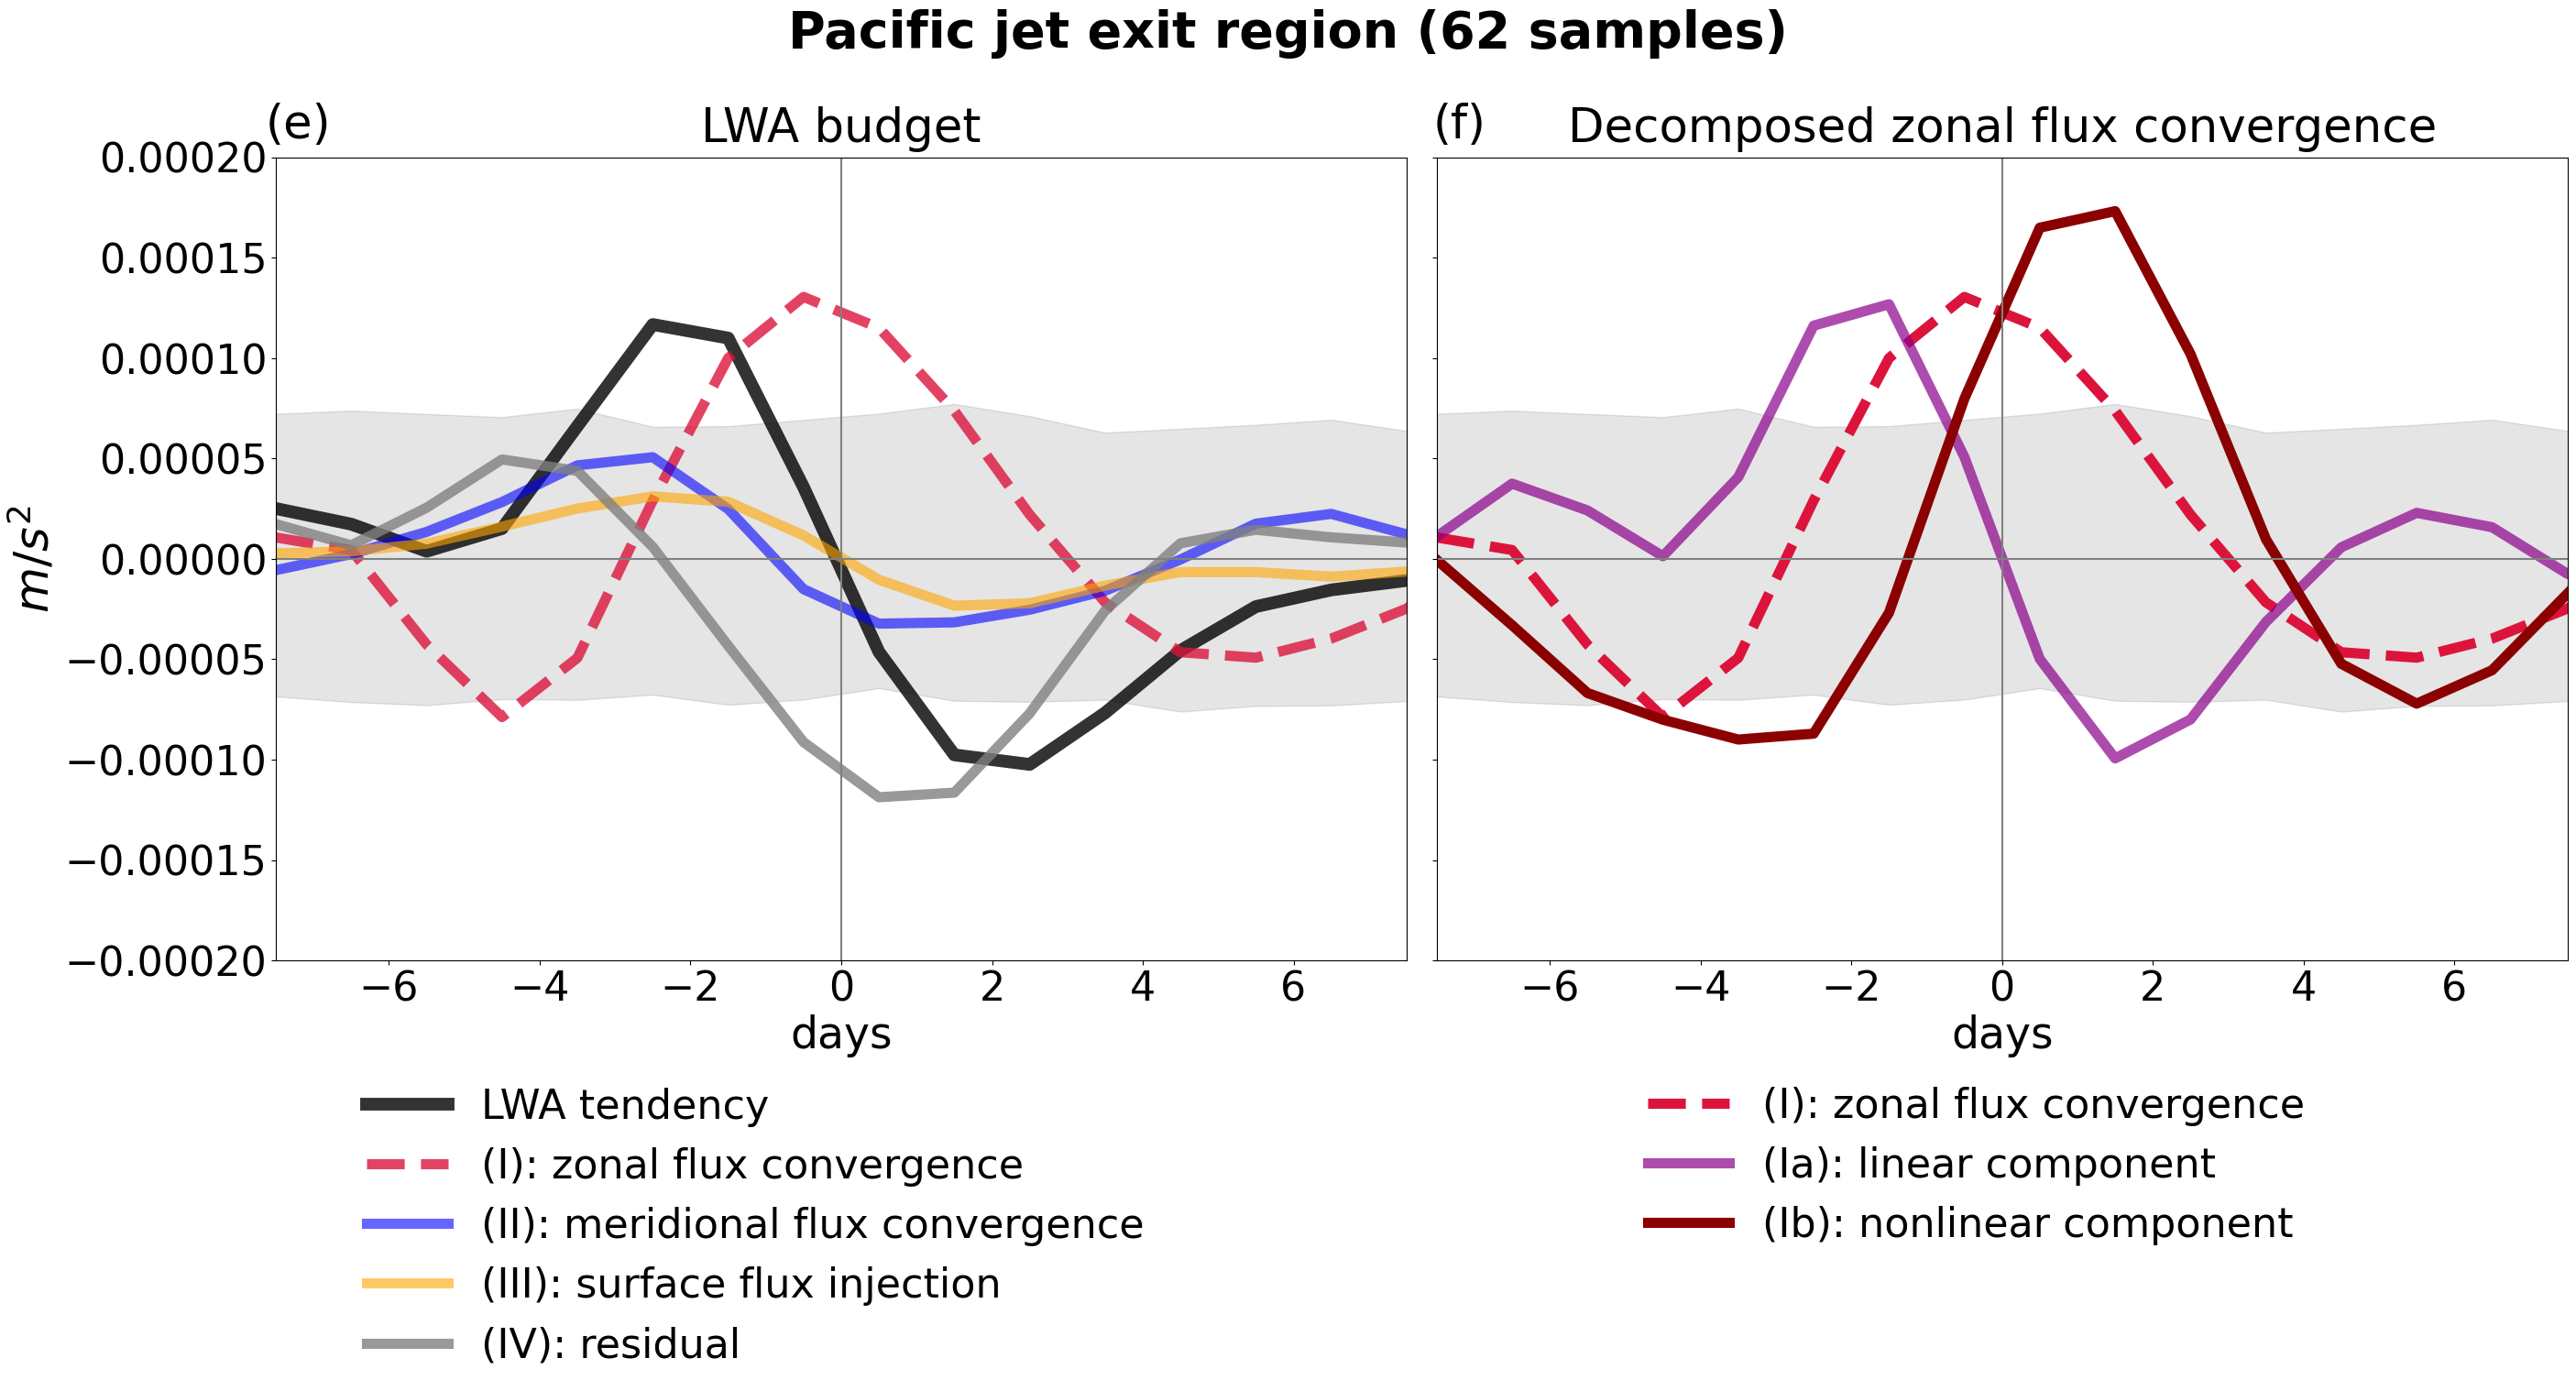

In [22]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of wave-activity blocks during DJF \n\n Global composites (%d samples)'%(no_of_events), fontsize=FONTSIZE+8, color='k', y=1.15, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)

for ax, label in zip(axs, ['(a)', '(b)']):
        ax.text(0.02, 1.04, label,  horizontalalignment='center', verticalalignment='center', \
            transform = ax.transAxes, fontsize=FONTSIZE+5)
#         ax.get_legend().remove()
    
dest = './nnn_suggestions/'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_all_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_all_4-18.pdf', bbox_inches='tight')

print (no_of_events)



########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Atlantic jet exit']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Atlantic jet exit region (%d samples)'%(no_of_events), fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)

for ax, label in zip(axs, ['(c)', '(d)']):
        ax.text(0.02, 1.04, label,  horizontalalignment='center', verticalalignment='center', \
            transform = ax.transAxes, fontsize=FONTSIZE+5)
#         ax.get_legend().remove()
    
dest = './nnn_suggestions/'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_Atlantic-jet-exit_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_Atlantic-jet-exit_4-18.pdf', bbox_inches='tight')

print (no_of_events)

########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Pacific jet exit']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Pacific jet exit region (%d samples)'%(no_of_events), fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)

for ax, label in zip(axs, ['(e)', '(f)']):
        ax.text(0.02, 1.04, label,  horizontalalignment='center', verticalalignment='center', \
            transform = ax.transAxes, fontsize=FONTSIZE+5)
    
dest = './nnn_suggestions/'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_Pacific-jet-exit_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_Pacific-jet-exit_4-18.pdf', bbox_inches='tight')

print (no_of_events)

# Rough

In [73]:
def plot_lifecycle(key='dA', co='k', STD=False, dictionary_phase3=dictionary,  \
                   lw=4, position='center', lon_edge=20, ax=None, FONTSIZE=20, \
                   ALPHA=1, linestyle='-', each_event=False, thin_lw=1, sign=1):
    
    if ax is None:
        ax = py
    dicti = return_mean_std(key = key, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    
    if each_event:
        for n in range(dicti['event'].shape[0]):
            ax.plot(dictionary_phase3['timing'], dicti['event'][n,...], '-', lw=thin_lw, color=co, alpha=0.1)
    if STD:
        mini = return_mean_std(key = 'dA_dt_low_ci', dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
        maxi = return_mean_std(key = 'dA_dt_high_ci', dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
        ax.fill_between(dictionary_phase3['timing'], mini['mean'], maxi['mean'], color=co, alpha=0.1)
        
    else:
        ax.plot(dictionary_phase3['timing'], sign*dicti['mean'], linestyle, lw=lw, label = make_latex(dictionary_phase3['var_names'][key]), color=co, alpha=ALPHA)
#         ax.errorbar(dictionary_phase3['timing'], dicti['mean'], yerr=dicti['std'],\
#             ecolor=co, ls='', alpha=alpha, color=color)




def plot_lifecycle_sum(key1='dA', key2='dA', co='k', STD=False, dictionary_phase3=dictionary, lw=4, position='center', \
                       lon_edge=20, ax=None, FONTSIZE=20, ALPHA=1, linestyle='-',  each_event=False, thin_lw=1, sign=1):
    if ax is None:
        ax = py  
    dicti1 = return_mean_std(key = key1, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    dicti2 = return_mean_std(key = key2, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge)
    
    if each_event:
        for n in range(dicti1['event'].shape[0]):
            ax.plot(dictionary_phase3['timing'], dicti1['event'][n,...]+dicti2['event'][n,...], linestyle, lw=thin_lw, color=co, alpha=0.1)

    if STD:
        ax.fill_between(dictionary_phase3['timing'], dicti1['mini'], dicti1['maxi'], color=co, alpha=0.1)
    else:
        ax.plot(dictionary_phase3['timing'], sign*(dicti1['mean']+dicti2['mean']), '-', lw=lw, \
                label = make_latex(dictionary_phase3['var_names']['F1+F3']), color=co, alpha=ALPHA)
 


def plot_F_decomposed_fluxes(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
             days = [4,5,6,7,8,9,10,11,12,13,14,15,16,17], phase='all', position='center', \
             lon_edge=20, FONTSIZE=20, extra_day=3, block_type='anticyclonic', YLIM = 0.00025, each_event=False, \
             total_data_dictionary=all_blocks_dictionary, ax=None):
    
    
    if ax is None:
        ax = py
    dictionary_phase3 =  return_block_cycle_synoptic(regions = regions, days = days, phase=phase, extra_day=extra_day, block_type=block_type, total_data_dictionary=total_data_dictionary) 

  
    plot_lifecycle(key='F', sign=1,  co='k', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)    
    ax.set_ylim(-300, 300)
    
    
    ax1 = ax
    plot_lifecycle(key='F2', sign=1/5, co='r', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax1, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)
    plot_lifecycle_sum(key1='F1', key2='F3',  sign=1/5,     co='b', lw=8, dictionary_phase3=dictionary_phase3, position=position, lon_edge=lon_edge, ax=ax1, FONTSIZE=FONTSIZE, ALPHA=0.8, each_event=each_event)

    
    no_of_events = dictionary_phase3['no_of_events']
#     ax.legend(bbox_to_anchor=(1,1), ncol=1)
    ax.tick_params(labelsize=FONTSIZE)
    
    ax.axvline(0, color='gray')

    return no_of_events, ax, ax1
   


def plot_lifecycle_fluxes_for_different_regions(N=0, regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], \
                                         region_name  = 'North Atlantic sector', days=np.arange(4,18,1), \
                                         FONTSIZE = 30, axs=None, fig=None, block_type='anticyclonic', YLIM= 0.00025, each_event=False, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[5,95], bbox_to_anchor=(0, -1), bbox_to_anchor2=(0.8, -0.55)):
    
    if axs is None:
        fig, axs = py.subplots(2, 2, figsize=(26,18), constrained_layout=True, sharey=True)

    if (len(axs.shape) > 1): 
        AX = axs[N,0]
        
    else:
        AX = axs[N]
    
    no_of_events, ax, ax1 = plot_F_decomposed_fluxes(regions = regions, \
                                 days = days, phase='all', ax=AX, FONTSIZE=FONTSIZE, \
                                 lon_edge=20, extra_day=3, block_type=block_type, YLIM=YLIM, each_event=each_event, \
                                 total_data_dictionary=total_data_dictionary)
        

    
    AX.tick_params(labelsize=FONTSIZE)
    AX.axvline(0, color='gray')
    AX.axhline(0, color='gray')
    
#     ax1.legend(loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False,  bbox_to_anchor=bbox_to_anchor)
#     ax.legend( loc='lower right', fontsize=FONTSIZE, ncol=1, frameon=False,  bbox_to_anchor=bbox_to_anchor)
    
    AX.set_xlabel('days', fontsize=FONTSIZE+2)


    return no_of_events
    
 
    
REGIONS_VARIABLE_NAMES = {'Global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60'],\
                          'Atlantic jet exit':      [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region))], \
                          'Pacific jet exit':       [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region))],\
                          'Atlantic jet entry':     [region for region in list(all_blocks_dictionary.keys()) if (('lonp60-p120' in region))], \
                          'Pacific jet entry':      [region for region in list(all_blocks_dictionary.keys()) if (('lonp120-p180' in region))]}


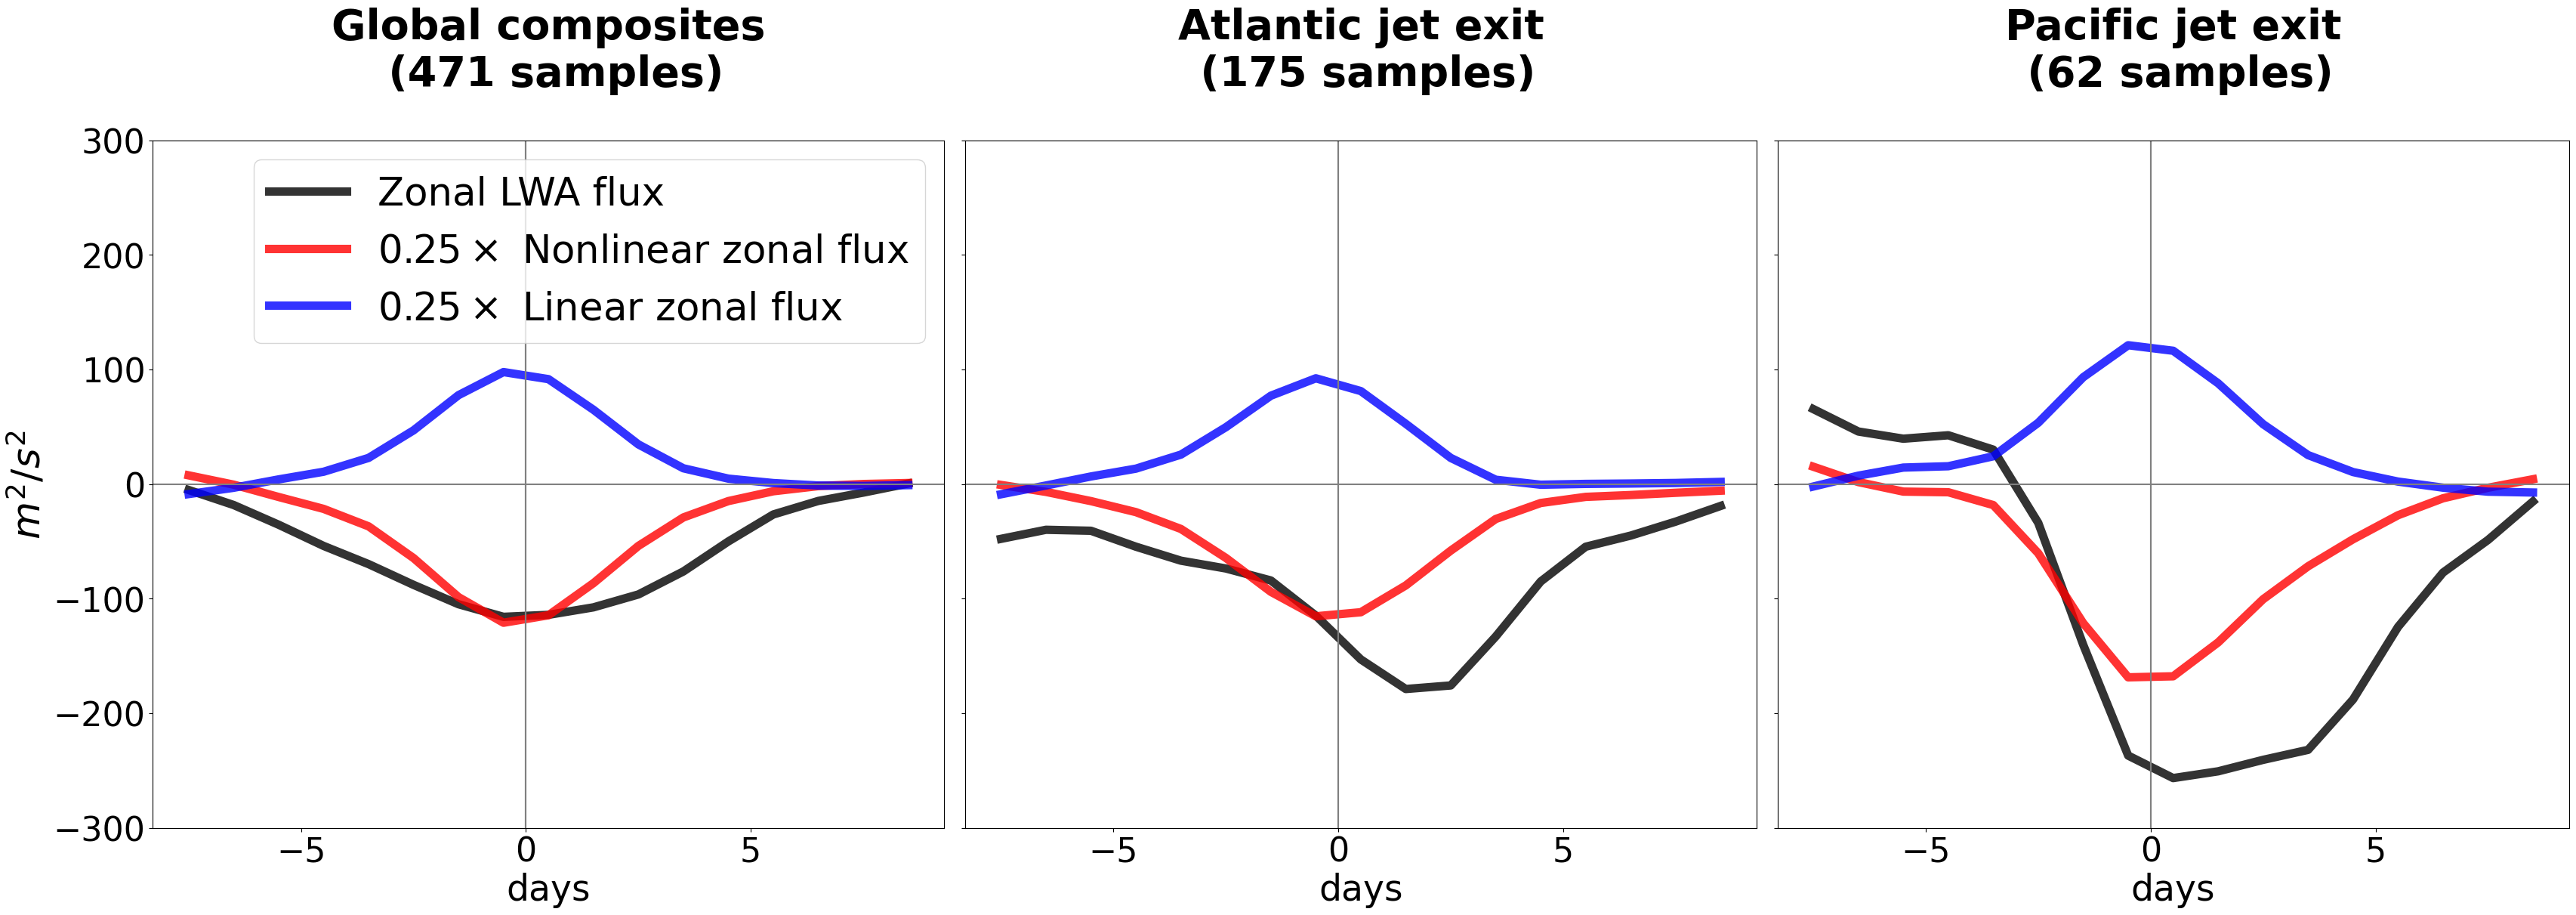

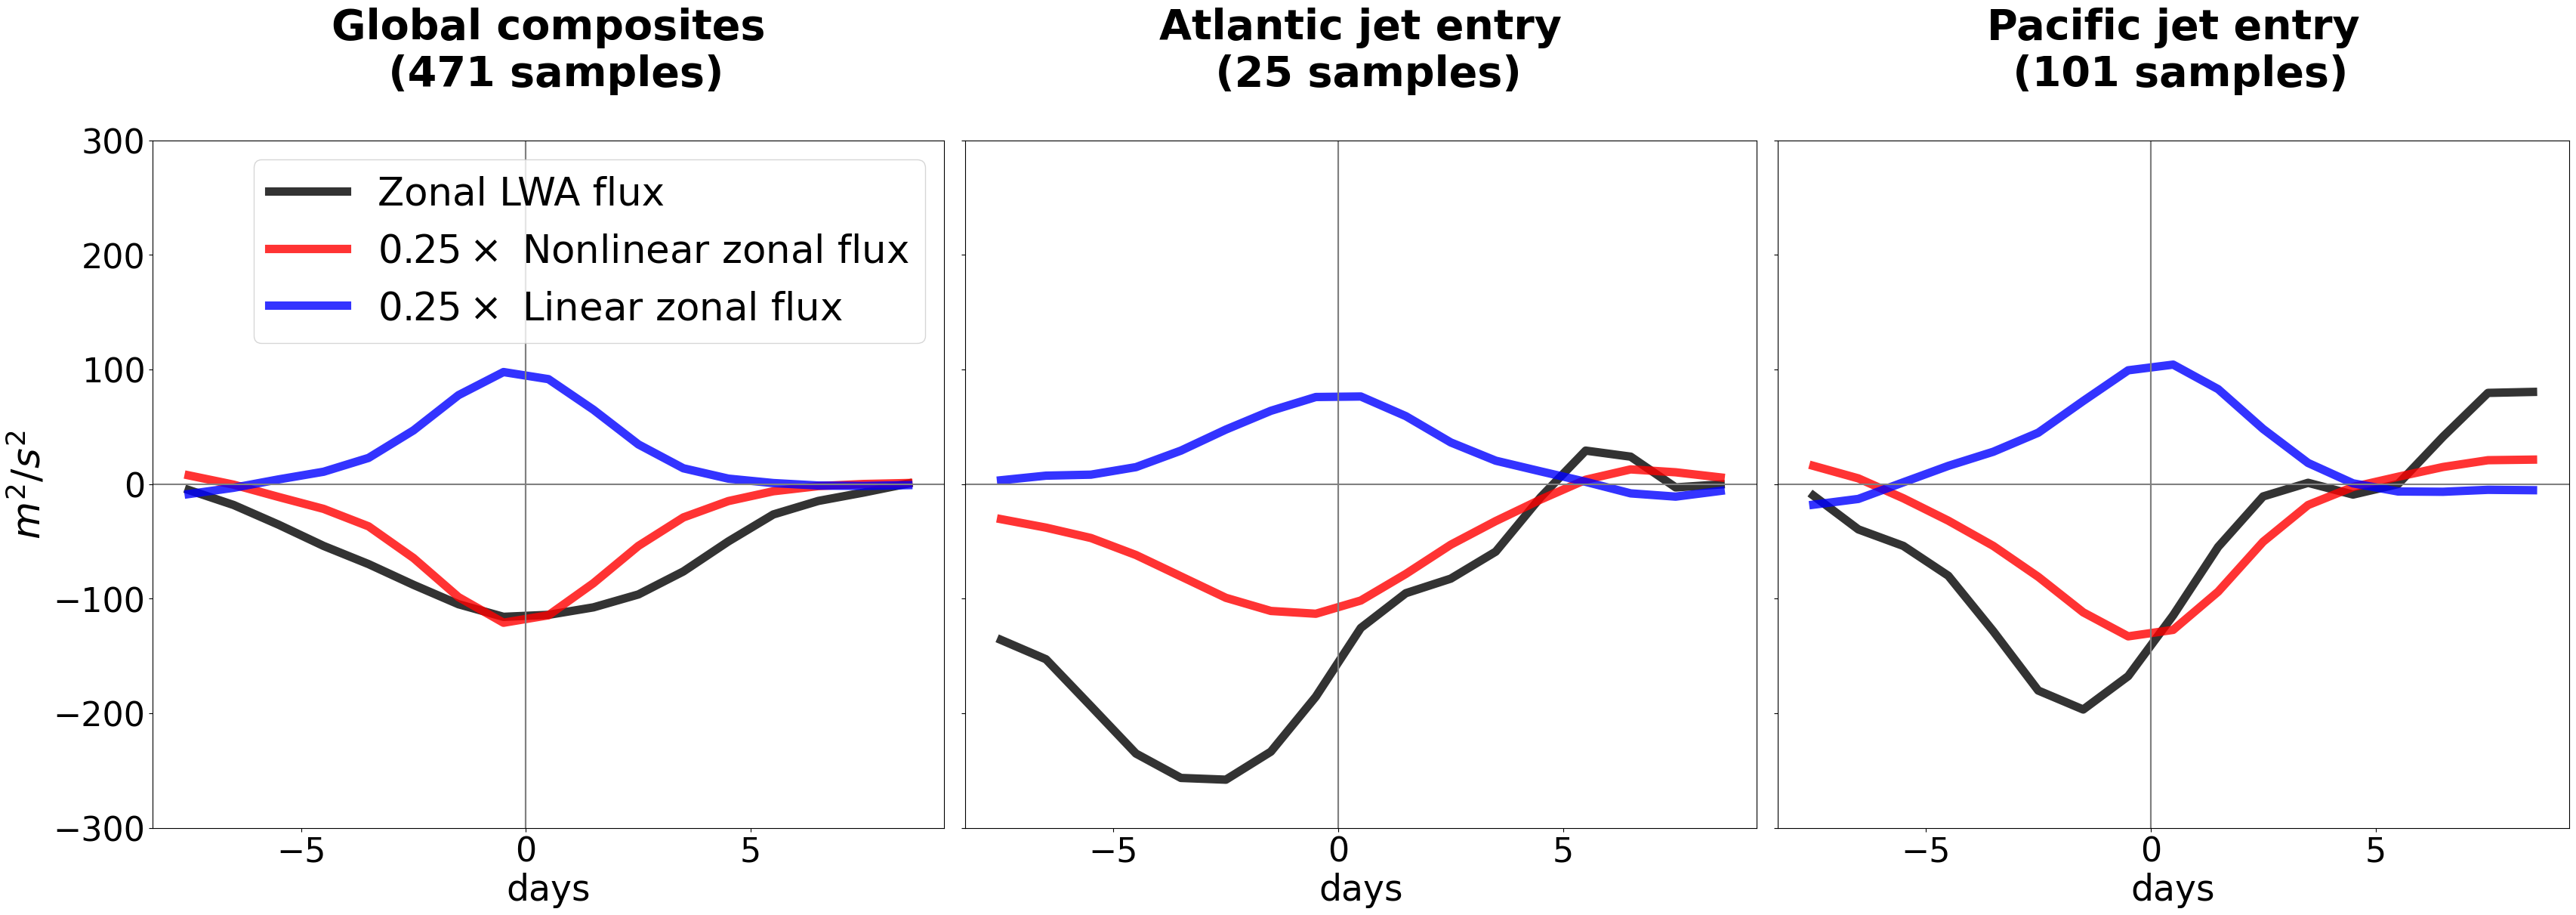

In [76]:
fig, axs = py.subplots(1, 3, figsize=(34,12), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites', 'Atlantic jet exit',  'Pacific jet exit',]):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_fluxes_for_different_regions(N=N, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.38), bbox_to_anchor2=(0.8, -0.50))       
    axs[N].set_title(region_name+'\n (%d samples)'%(no_of_events), fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')
#     print (N)

AX = axs[0]
AX.set_ylabel(r'$m^2/s^2$', fontsize=FONTSIZE+5)
AX.legend(loc='best', fontsize=FONTSIZE+5)

fig, axs = py.subplots(1, 3, figsize=(34,12), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites', 'Atlantic jet entry', 'Pacific jet entry',]):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_fluxes_for_different_regions(N=N, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.38), bbox_to_anchor2=(0.8, -0.50)) 
    axs[N].set_title(region_name+'\n (%d samples)'%(no_of_events), fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')
# fig.suptitle('Atlantic jet exit region', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')
#     print (N)

AX = axs[0]
AX.set_ylabel(r'$m^2/s^2$', fontsize=FONTSIZE+5)
AX.legend(loc='best', fontsize=FONTSIZE+5)


In [ ]:
'Global composites', 'Atlantic jet entry', 'Pacific jet entry'

In [ ]:
REGIONS_VARIABLE_NAMES = {'Global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60'],\
                          'Atlantic jet exit':      [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region))], \
                          'Pacific jet exit':       [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region))]}


dict_keys(['<dA/dt>', '<-dF/dx>', '<-dEPy/dy>', '<-dEPz/dz>', '<-dF_linear/dx>', '<-dF1/dx>', '<-dF2/dx>', '<-dF3/dx>', 'loni', 'lati', 'phase', 'timing', 'residual', 'no_of_events', 'A', 'F', 'F1', 'F2', 'F3', 'F_EPy', 'F_EPz', 'var_strings', 'var_names', 'persistence', 'dA_dt_low_ci', 'dA_dt_high_ci'])
dict_keys(['<dA/dt>', '<-dF/dx>', '<-dEPy/dy>', '<-dEPz/dz>', '<-dF_linear/dx>', '<-dF1/dx>', '<-dF2/dx>', '<-dF3/dx>', 'loni', 'lati', 'phase', 'timing', 'residual', 'no_of_events', 'A', 'F', 'F1', 'F2', 'F3', 'F_EPy', 'F_EPz', 'var_strings', 'var_names', 'persistence', 'dA_dt_low_ci', 'dA_dt_high_ci'])
dict_keys(['<dA/dt>', '<-dF/dx>', '<-dEPy/dy>', '<-dEPz/dz>', '<-dF_linear/dx>', '<-dF1/dx>', '<-dF2/dx>', '<-dF3/dx>', 'loni', 'lati', 'phase', 'timing', 'residual', 'no_of_events', 'A', 'F', 'F1', 'F2', 'F3', 'F_EPy', 'F_EPz', 'var_strings', 'var_names', 'persistence', 'dA_dt_low_ci', 'dA_dt_high_ci'])
dict_keys(['<dA/dt>', '<-dF/dx>', '<-dEPy/dy>', '<-dEPz/dz>', '<-dF_linear/dx>', '

Text(0, 0.5, '$m^2/s^2$')

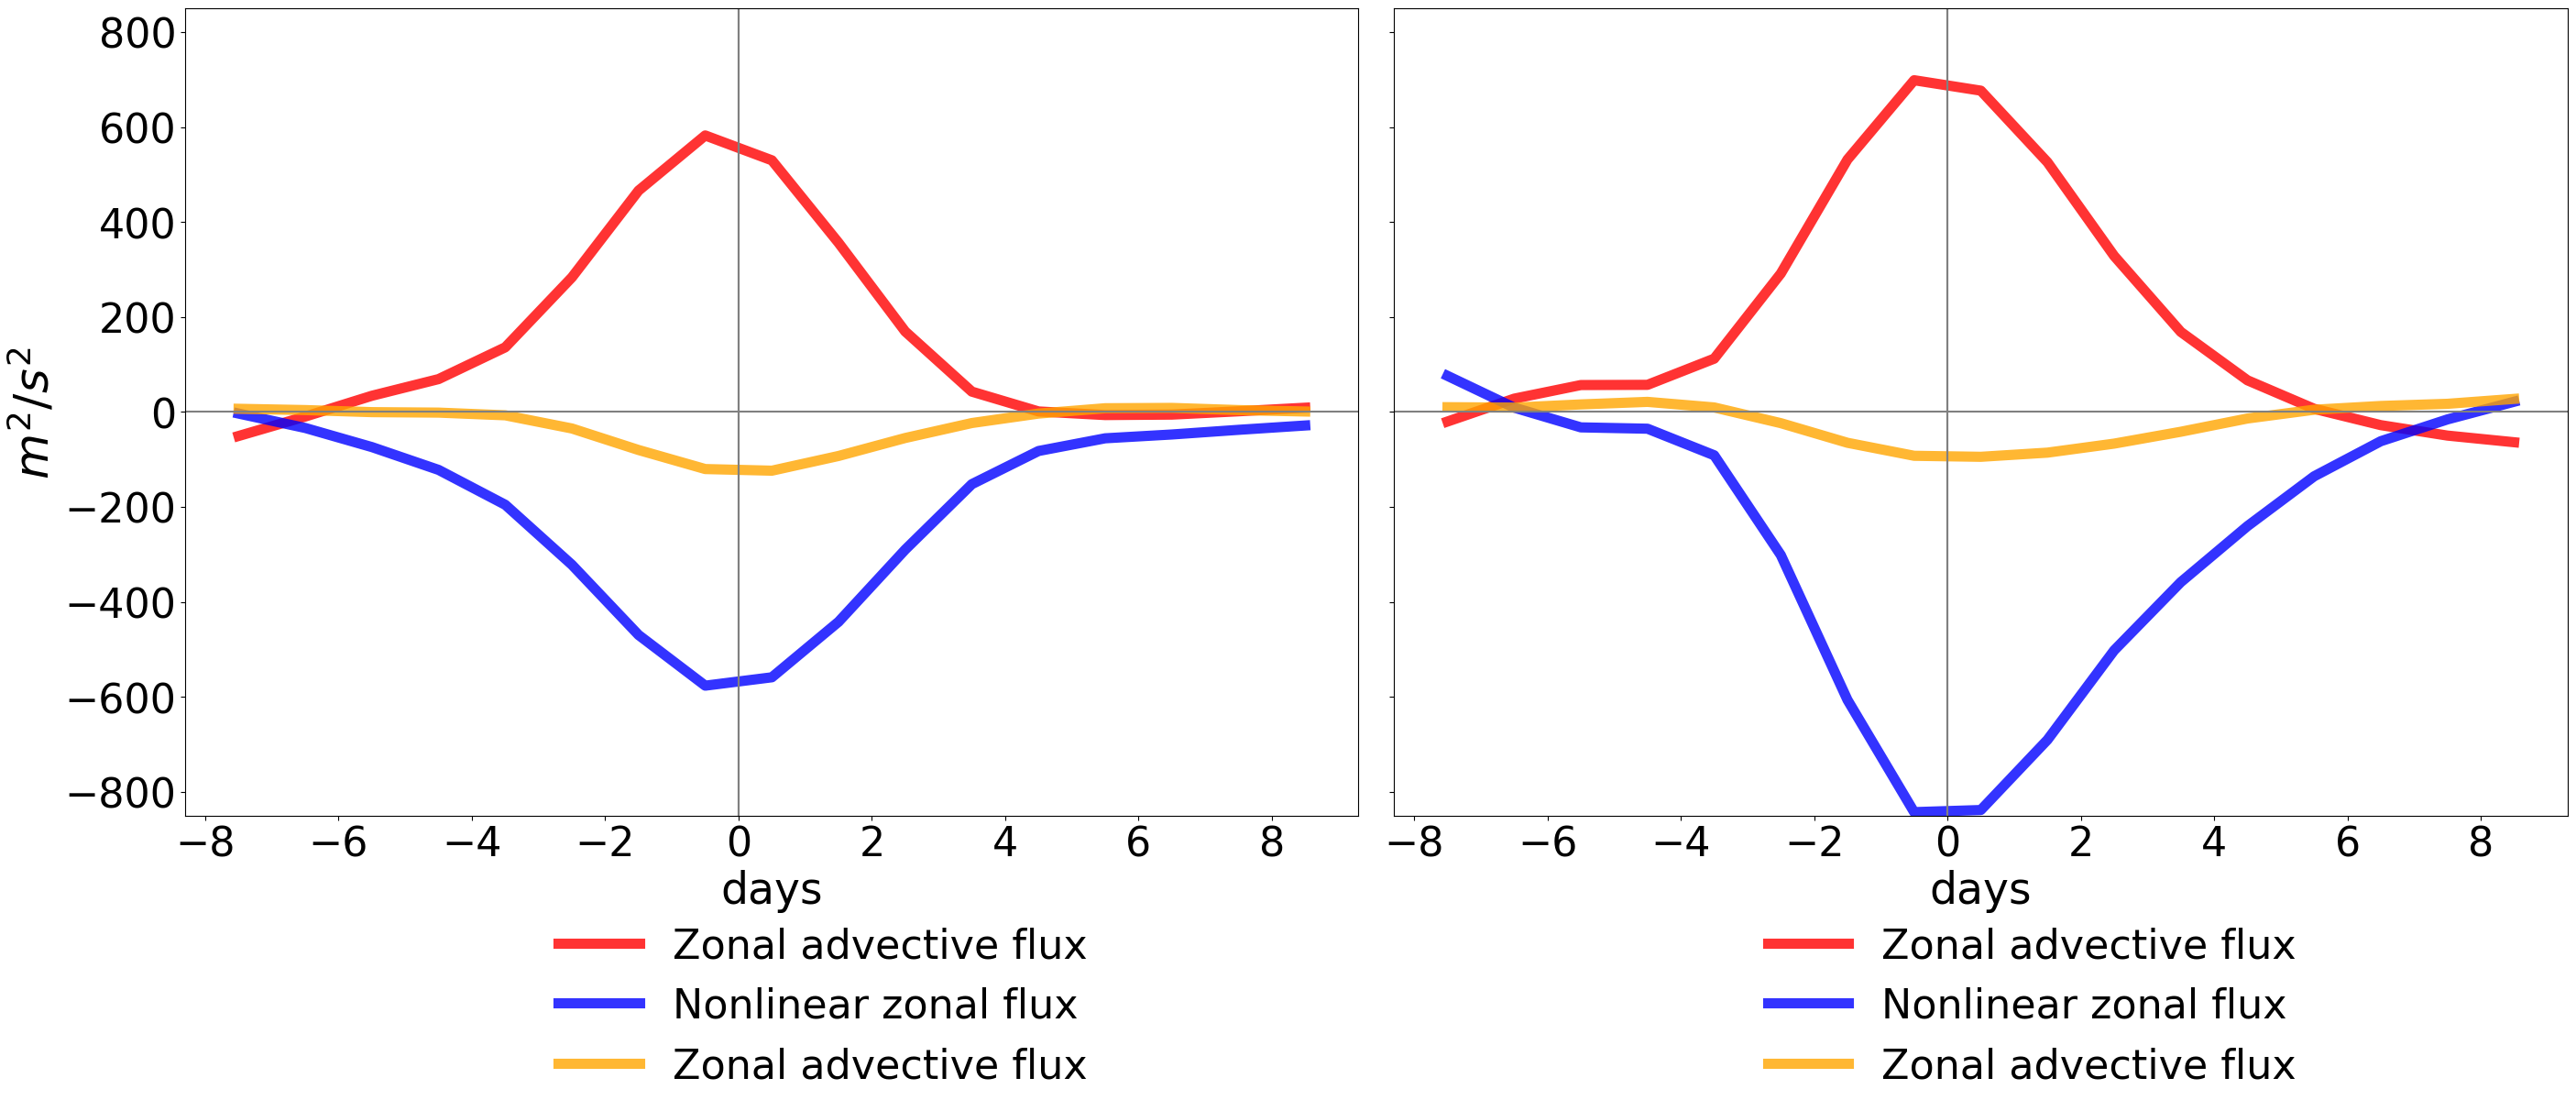

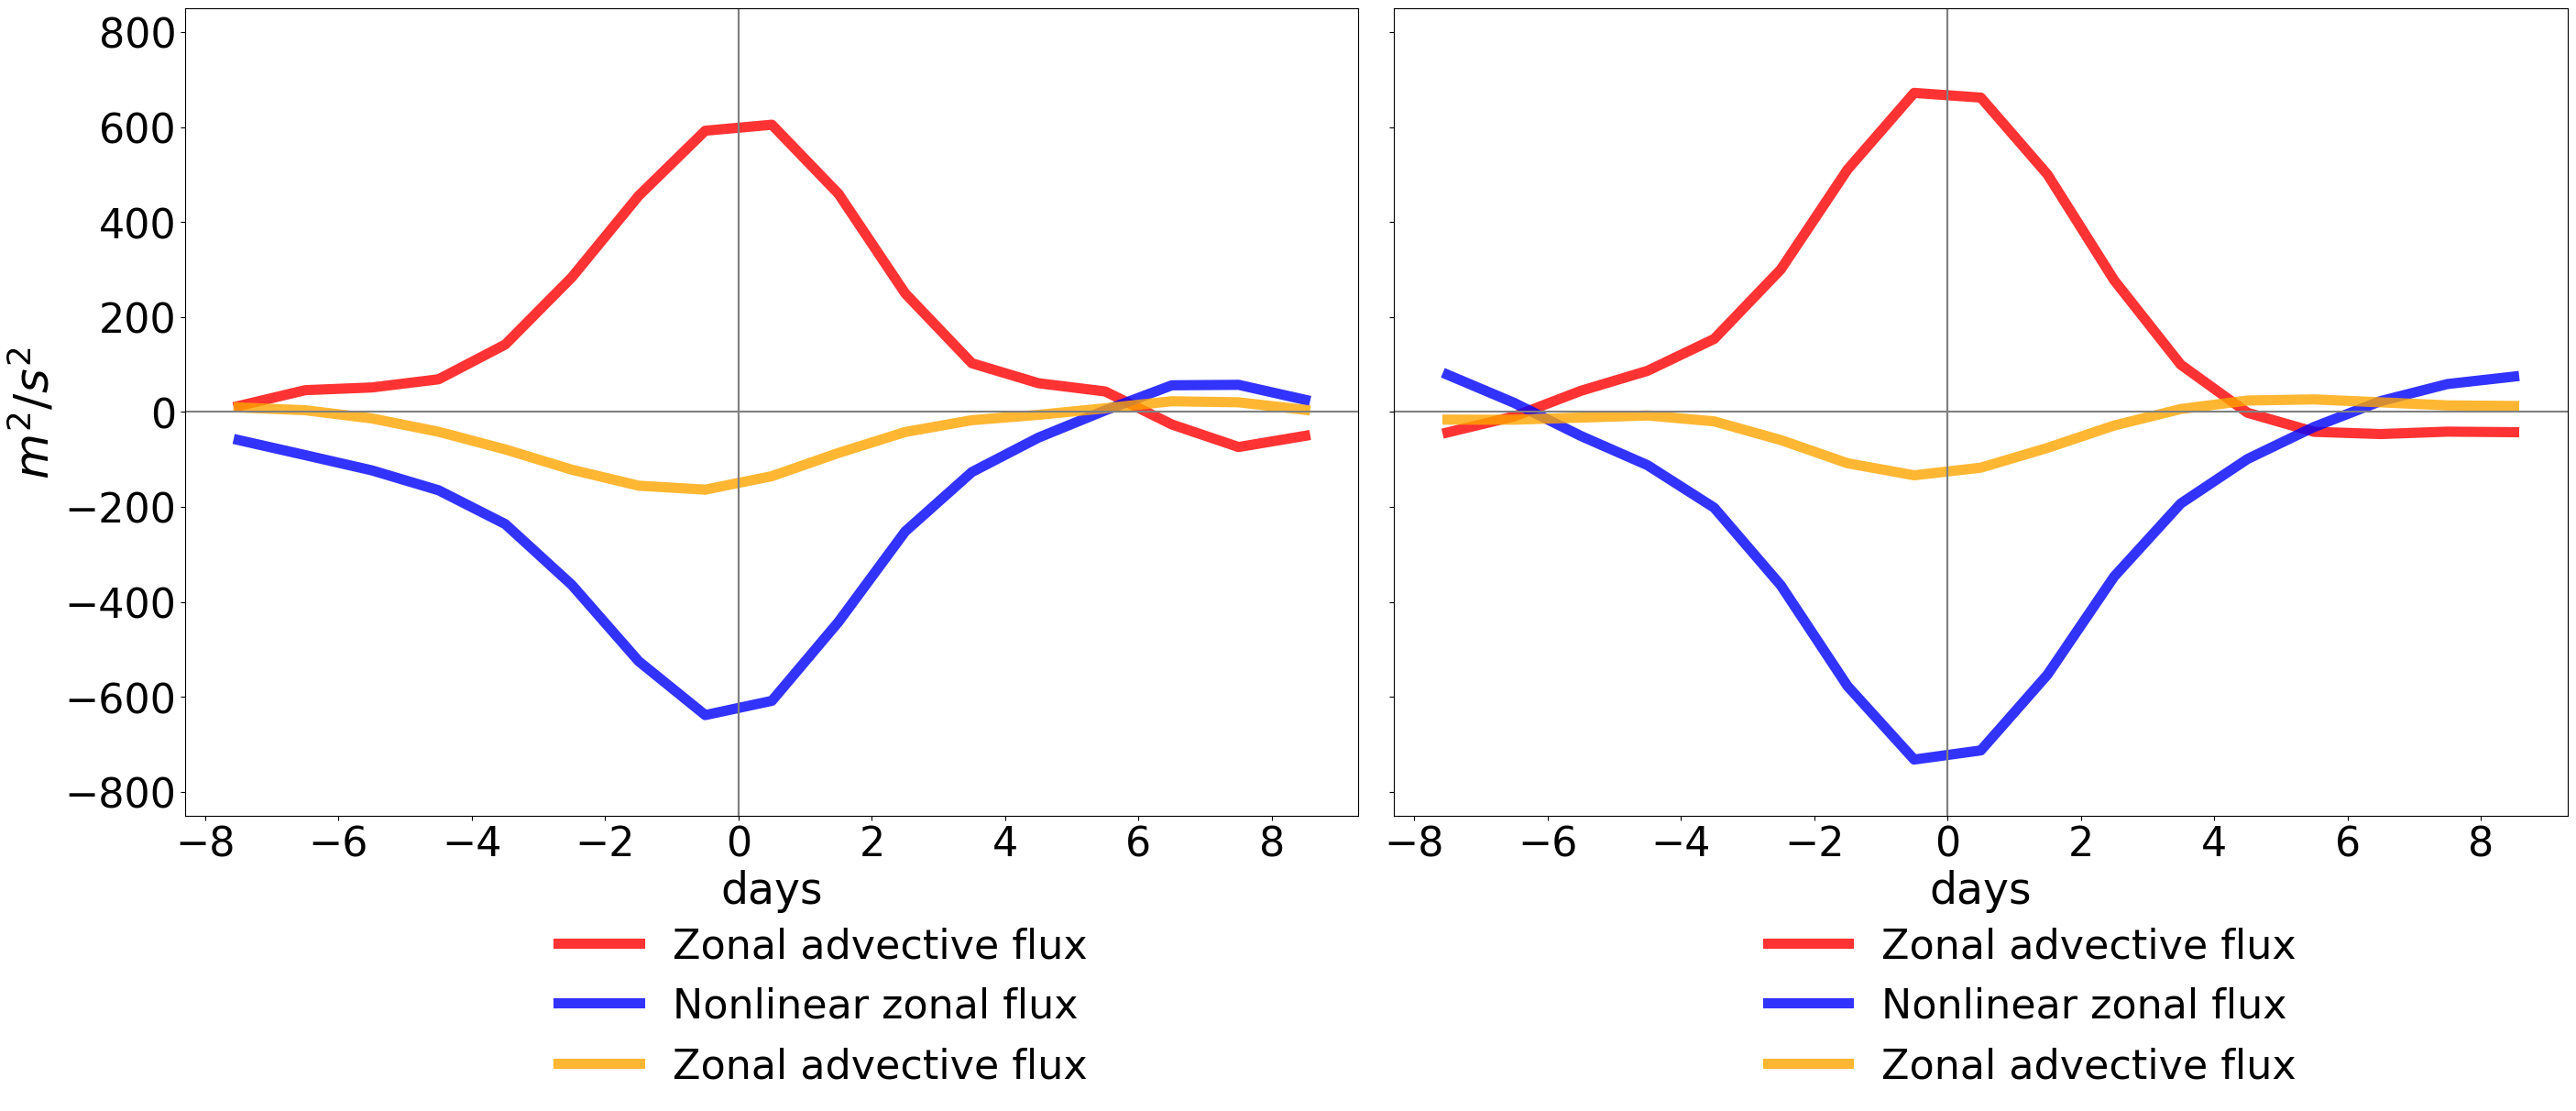

In [146]:
fig, axs = py.subplots(1, 2, figsize=(28,12), constrained_layout=True,  sharey=True)


FONTSIZE = 32

for N, region_name in enumerate(['Atlantic jet exit', 'Pacific jet exit']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_fluxes_for_different_regions(N=N, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.38), bbox_to_anchor2=(0.8, -0.40))       
# fig.suptitle('Atlantic jet exit region', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m^2/s^2$', fontsize=FONTSIZE+5)



fig, axs = py.subplots(1, 2, figsize=(28,12), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Land cluster', 'North Pacific sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_fluxes_for_different_regions(N=N, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.38), bbox_to_anchor2=(0.8, -0.40))       
# fig.suptitle('Atlantic jet exit region', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m^2/s^2$', fontsize=FONTSIZE+5)


In [ ]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Atlantic jet exit']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Atlantic jet exit region', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = './'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_Atlantic-jet-exit_4-18.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_Atlantic-jet-exit_4-18.pdf', bbox_inches='tight')


########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Pacific jet exit']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    no_of_events = plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Pacific jet exit region', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = './'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_Pacific-jet-exit_4-18.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_Pacific-jet-exit_4-18.pdf', bbox_inches='tight')


# Anticyclonic event

In [14]:
%%time
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
LWA_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_LWA_based.hkl')

# all_blocks_dictionary = LWA_blocks_dictionary

CPU times: user 4.88 s, sys: 18.7 s, total: 23.6 s
Wall time: 54.7 s


In [15]:
REGIONS_VARIABLE_NAMES = {'Global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60']  }
    

Text(0, 0.5, '$m/s^2$')

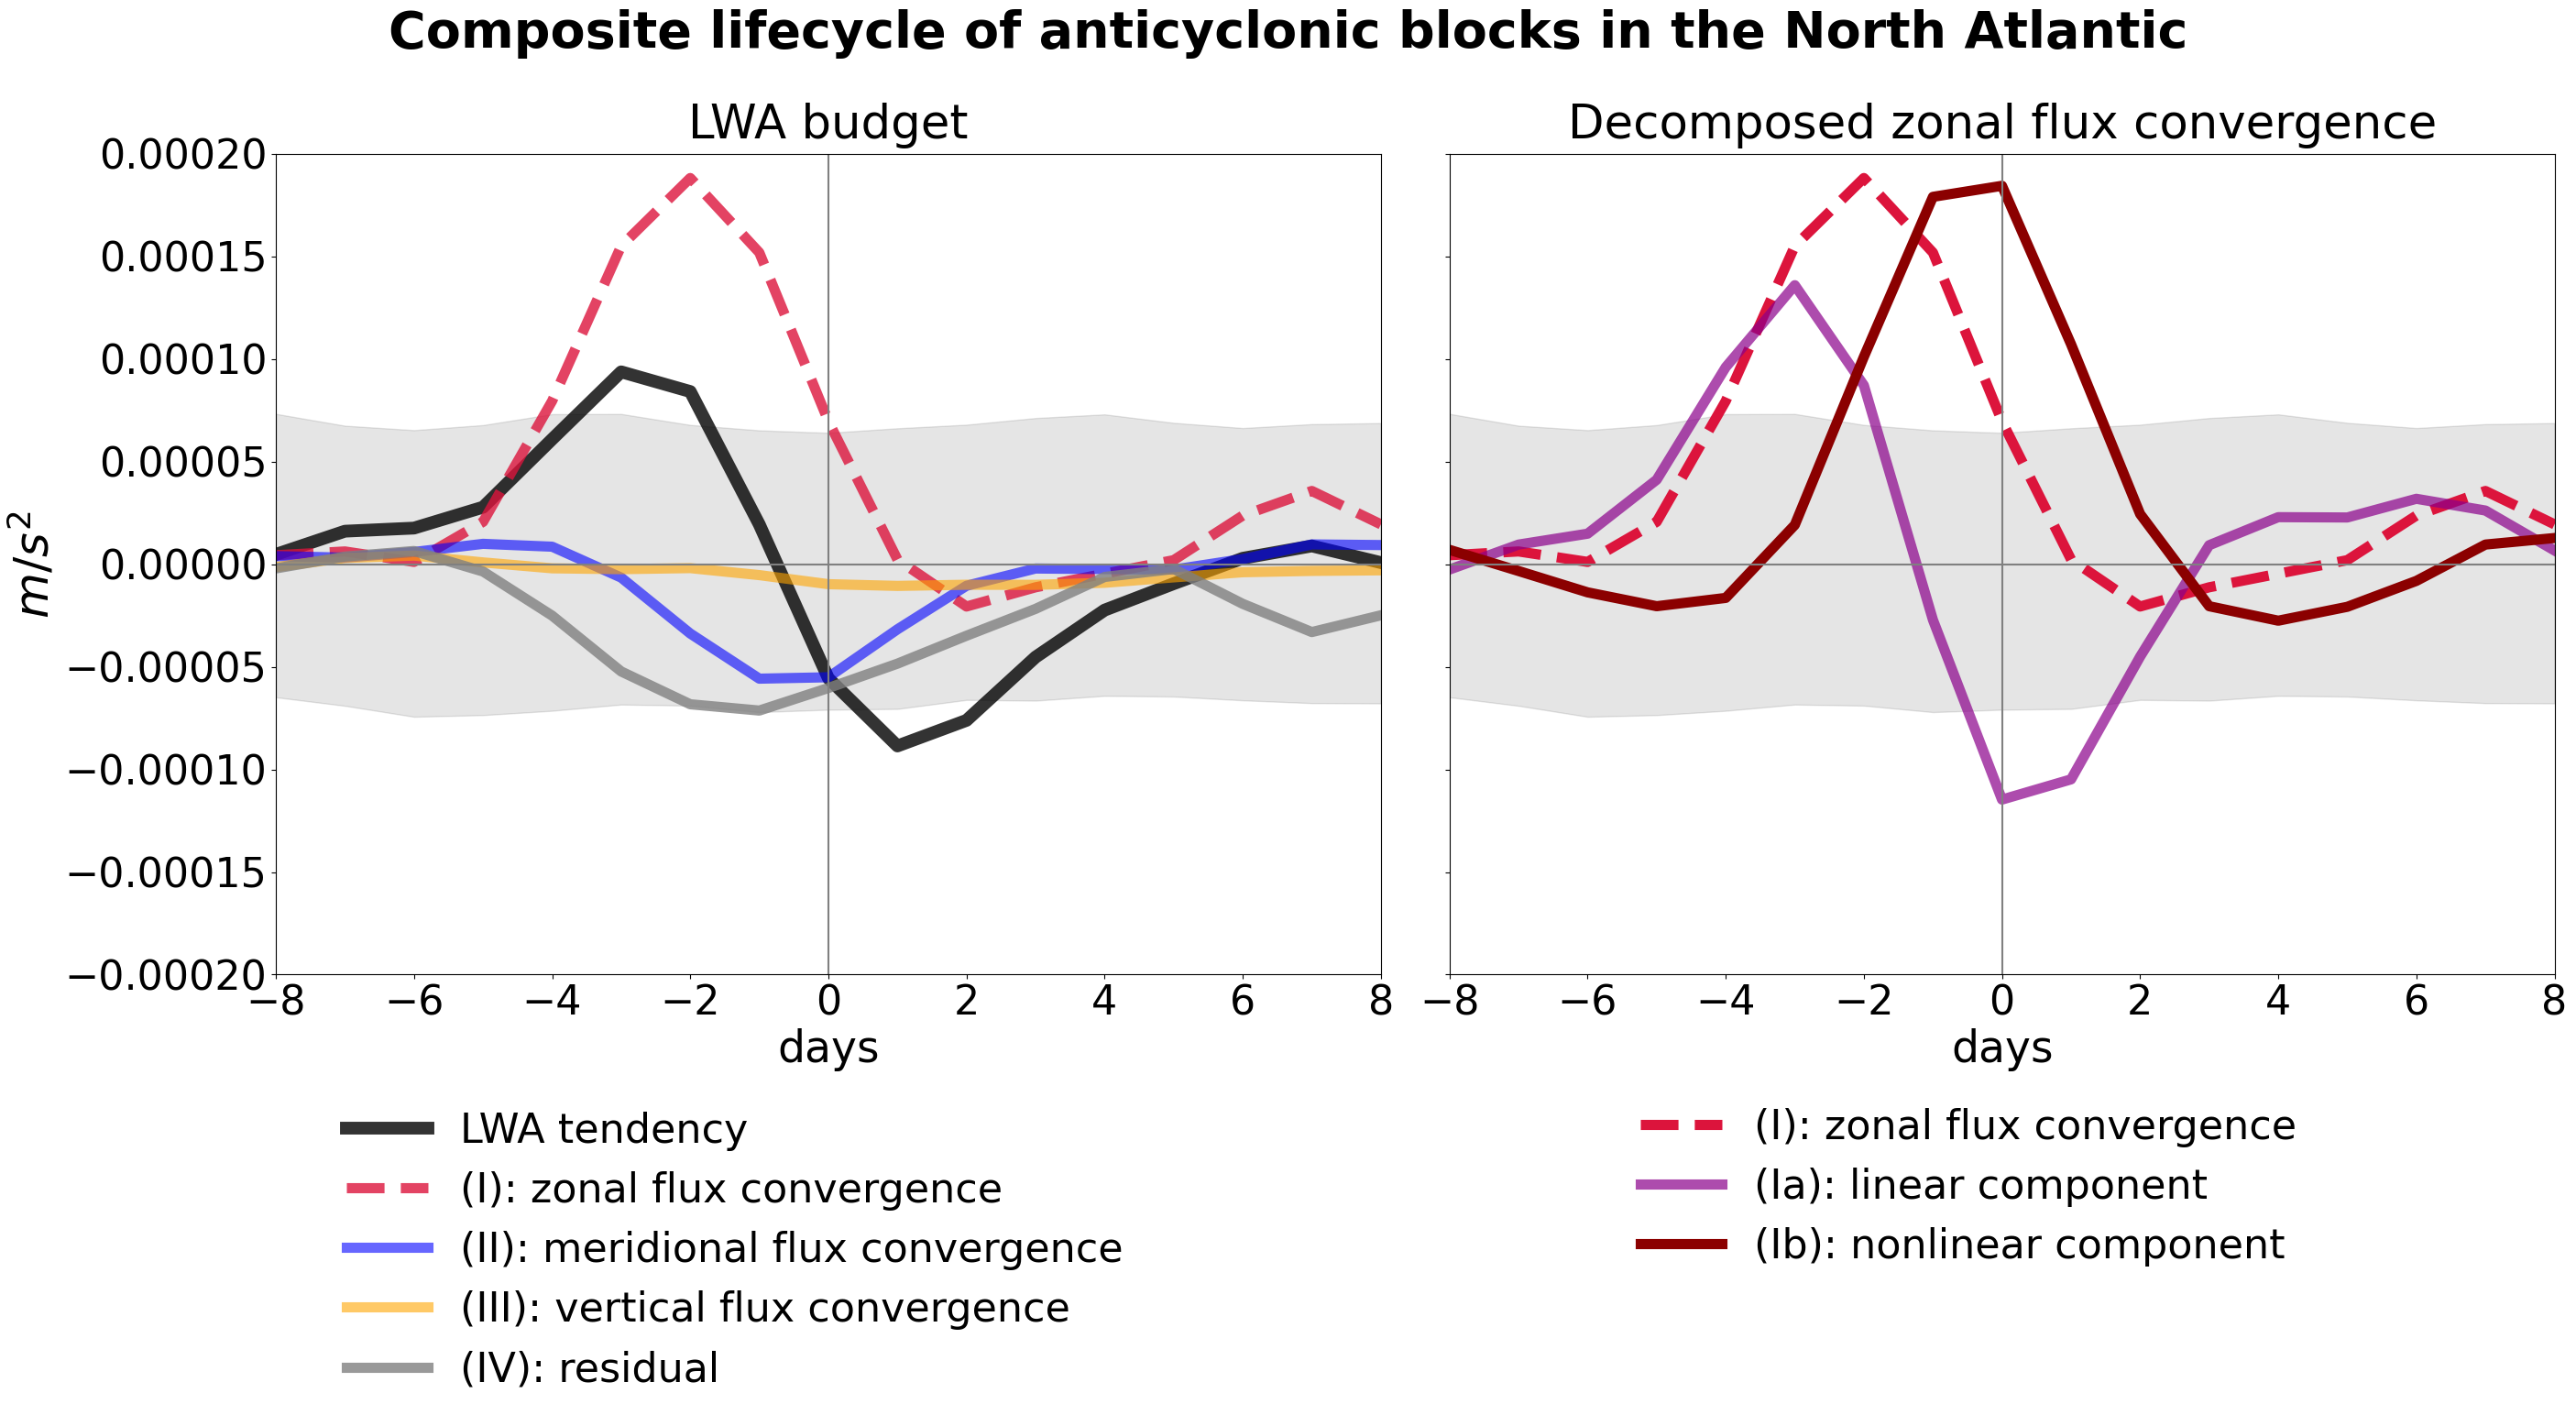

In [16]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Atlantic sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary , CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of anticyclonic blocks in the North Atlantic sector', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_anticyclonic_North_Atlantic sector_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_anticyclonic_North_Atlantic sector_4-18.pdf', bbox_inches='tight')



fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Pacific sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary , CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of anticyclonic blocks in the North Atlantic sector', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_anticyclonic_North_Pacific_sector_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_anticyclonic_North_Pacific_sector_4-18.pdf', bbox_inches='tight')


In [ ]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary , CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of anticyclonic blocks during winter', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_anticyclonic_all_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_anticyclonic_all_4-18.pdf', bbox_inches='tight')


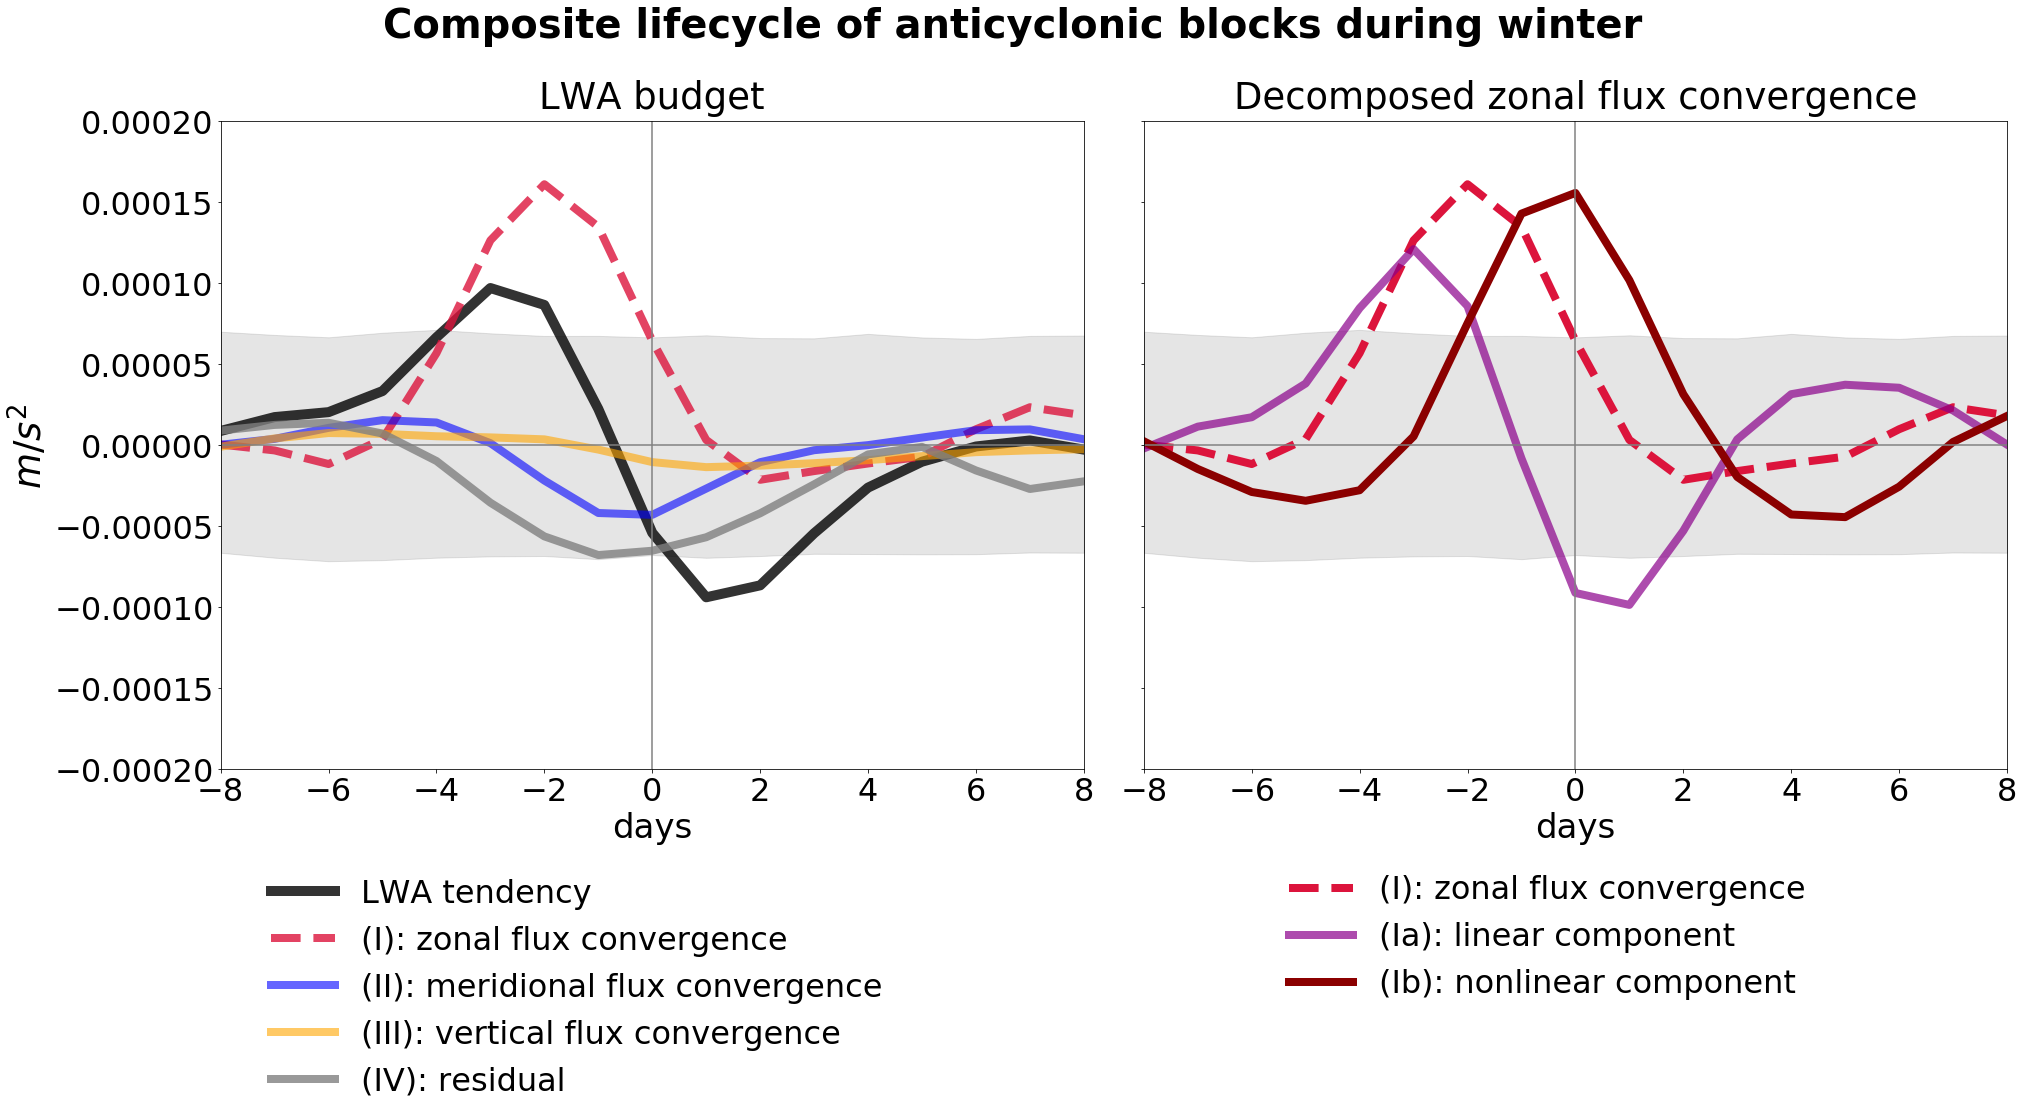

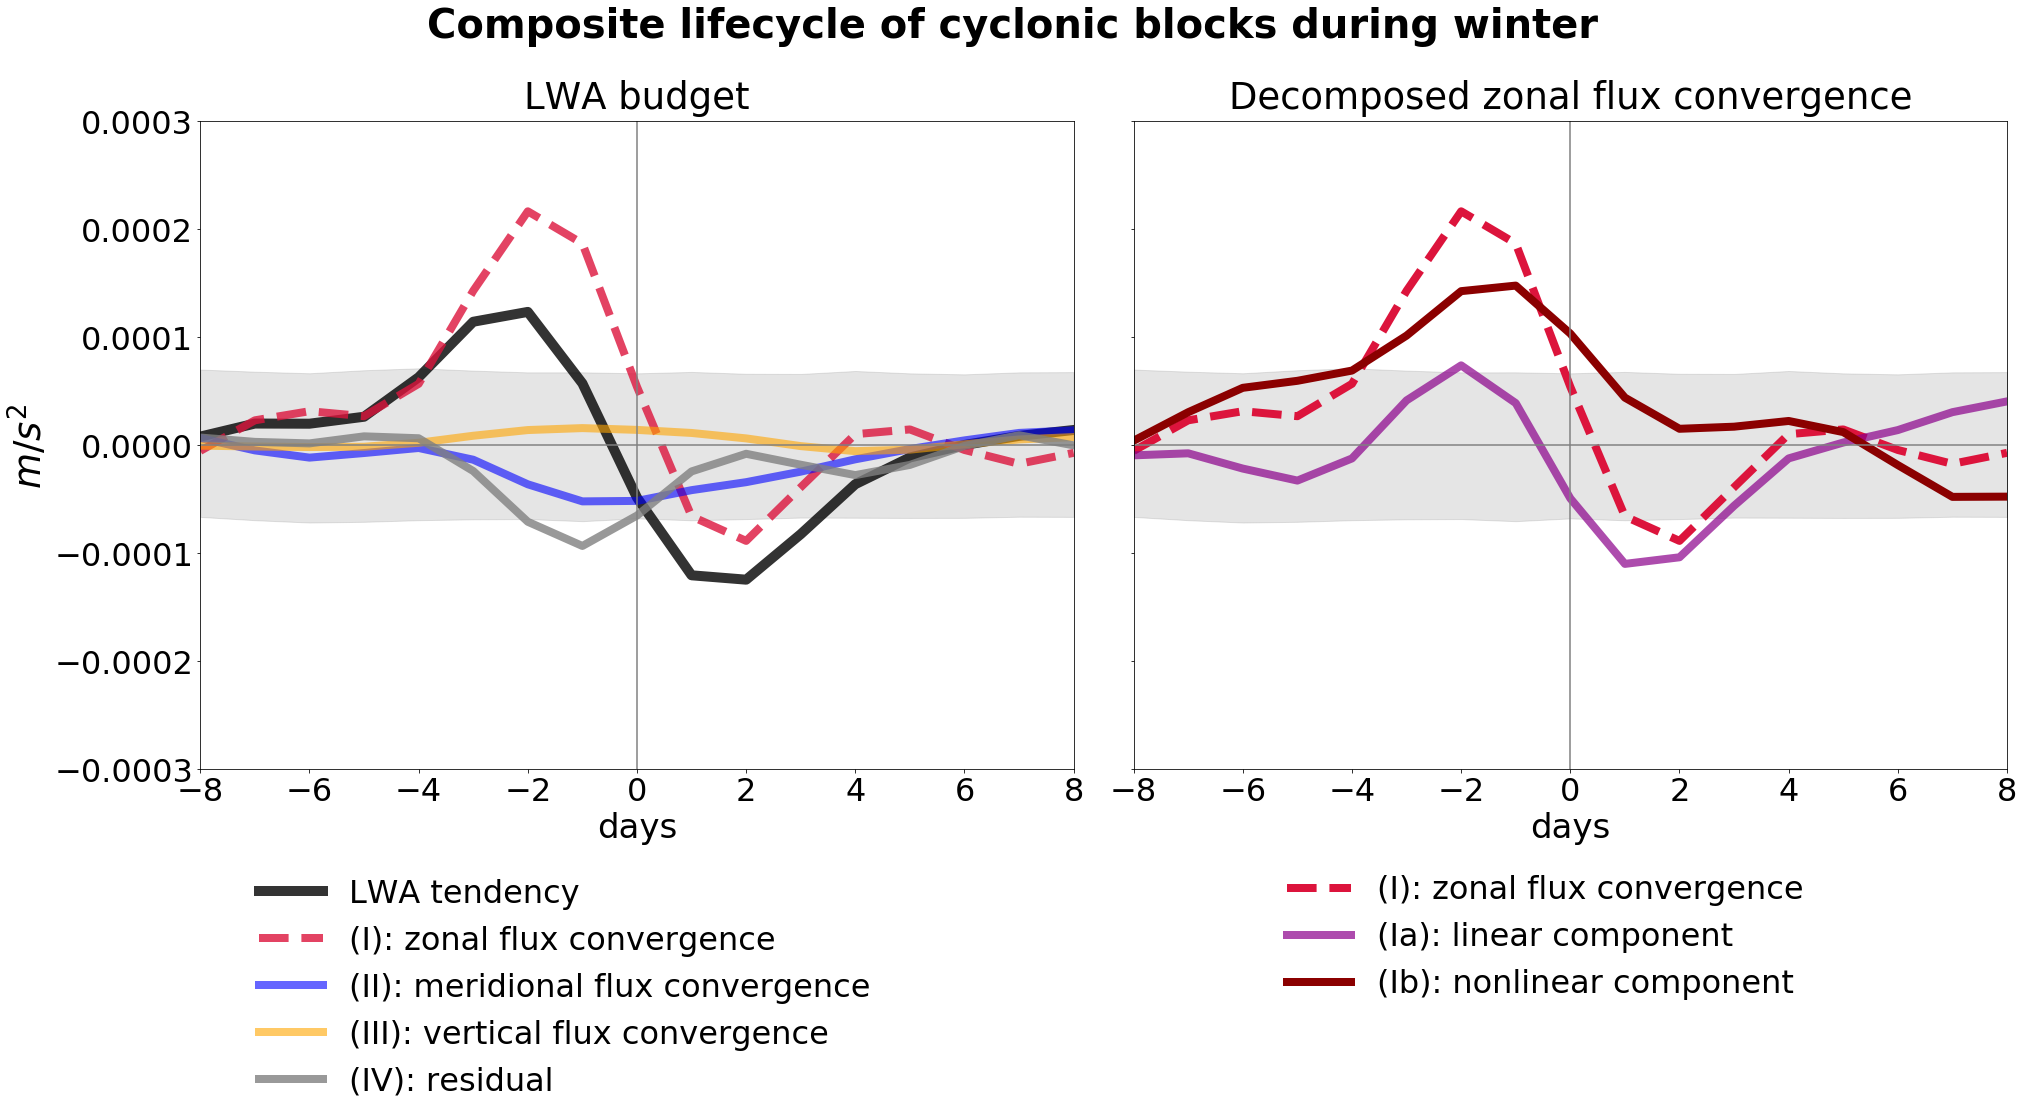

In [17]:
########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary , CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of anticyclonic blocks during winter', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_anticyclonic_all_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_anticyclonic_all_4-18.pdf', bbox_inches='tight')

########## 4-18 days

fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='cyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary , CI=[15, 85], bbox_to_anchor=(0.8, -0.55), bbox_to_anchor2=(0.8, -0.40))       
fig.suptitle('Composite lifecycle of cyclonic blocks during winter', fontsize=FONTSIZE+8, color='k', y=1.07, fontweight='bold')

AX = axs[0]
for ax in axs:
    ax.set_ylim(-0.00030, 0.00030)
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)

dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'Budget_lifecycle_cyclonic_all_4-18.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'Budget_lifecycle_cyclonic_all_4-18.pdf', bbox_inches='tight')

Text(0, 0.5, '$m/s^2$')

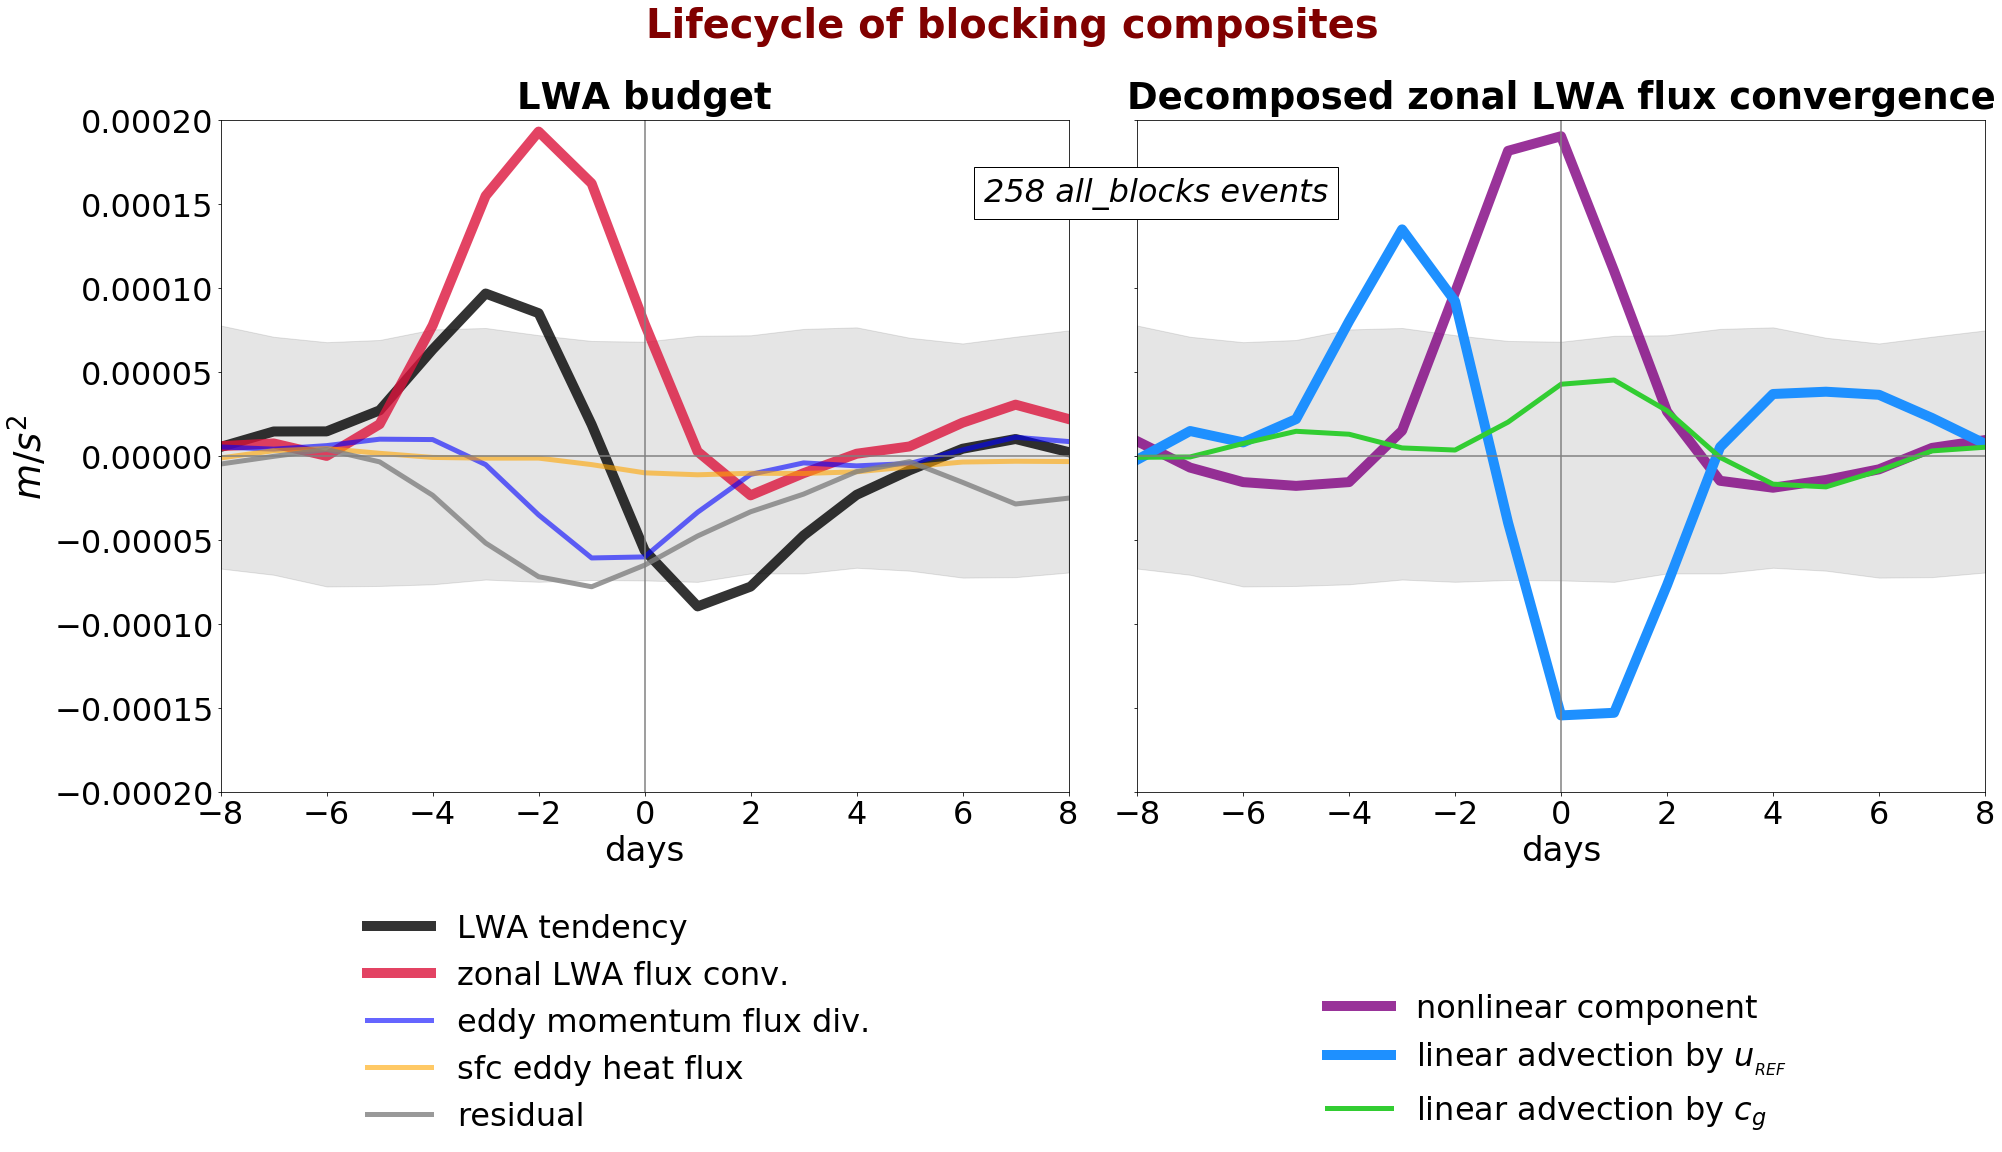

In [181]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Atlantic sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))       
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')



Text(0, 0.5, '$m/s^2$')

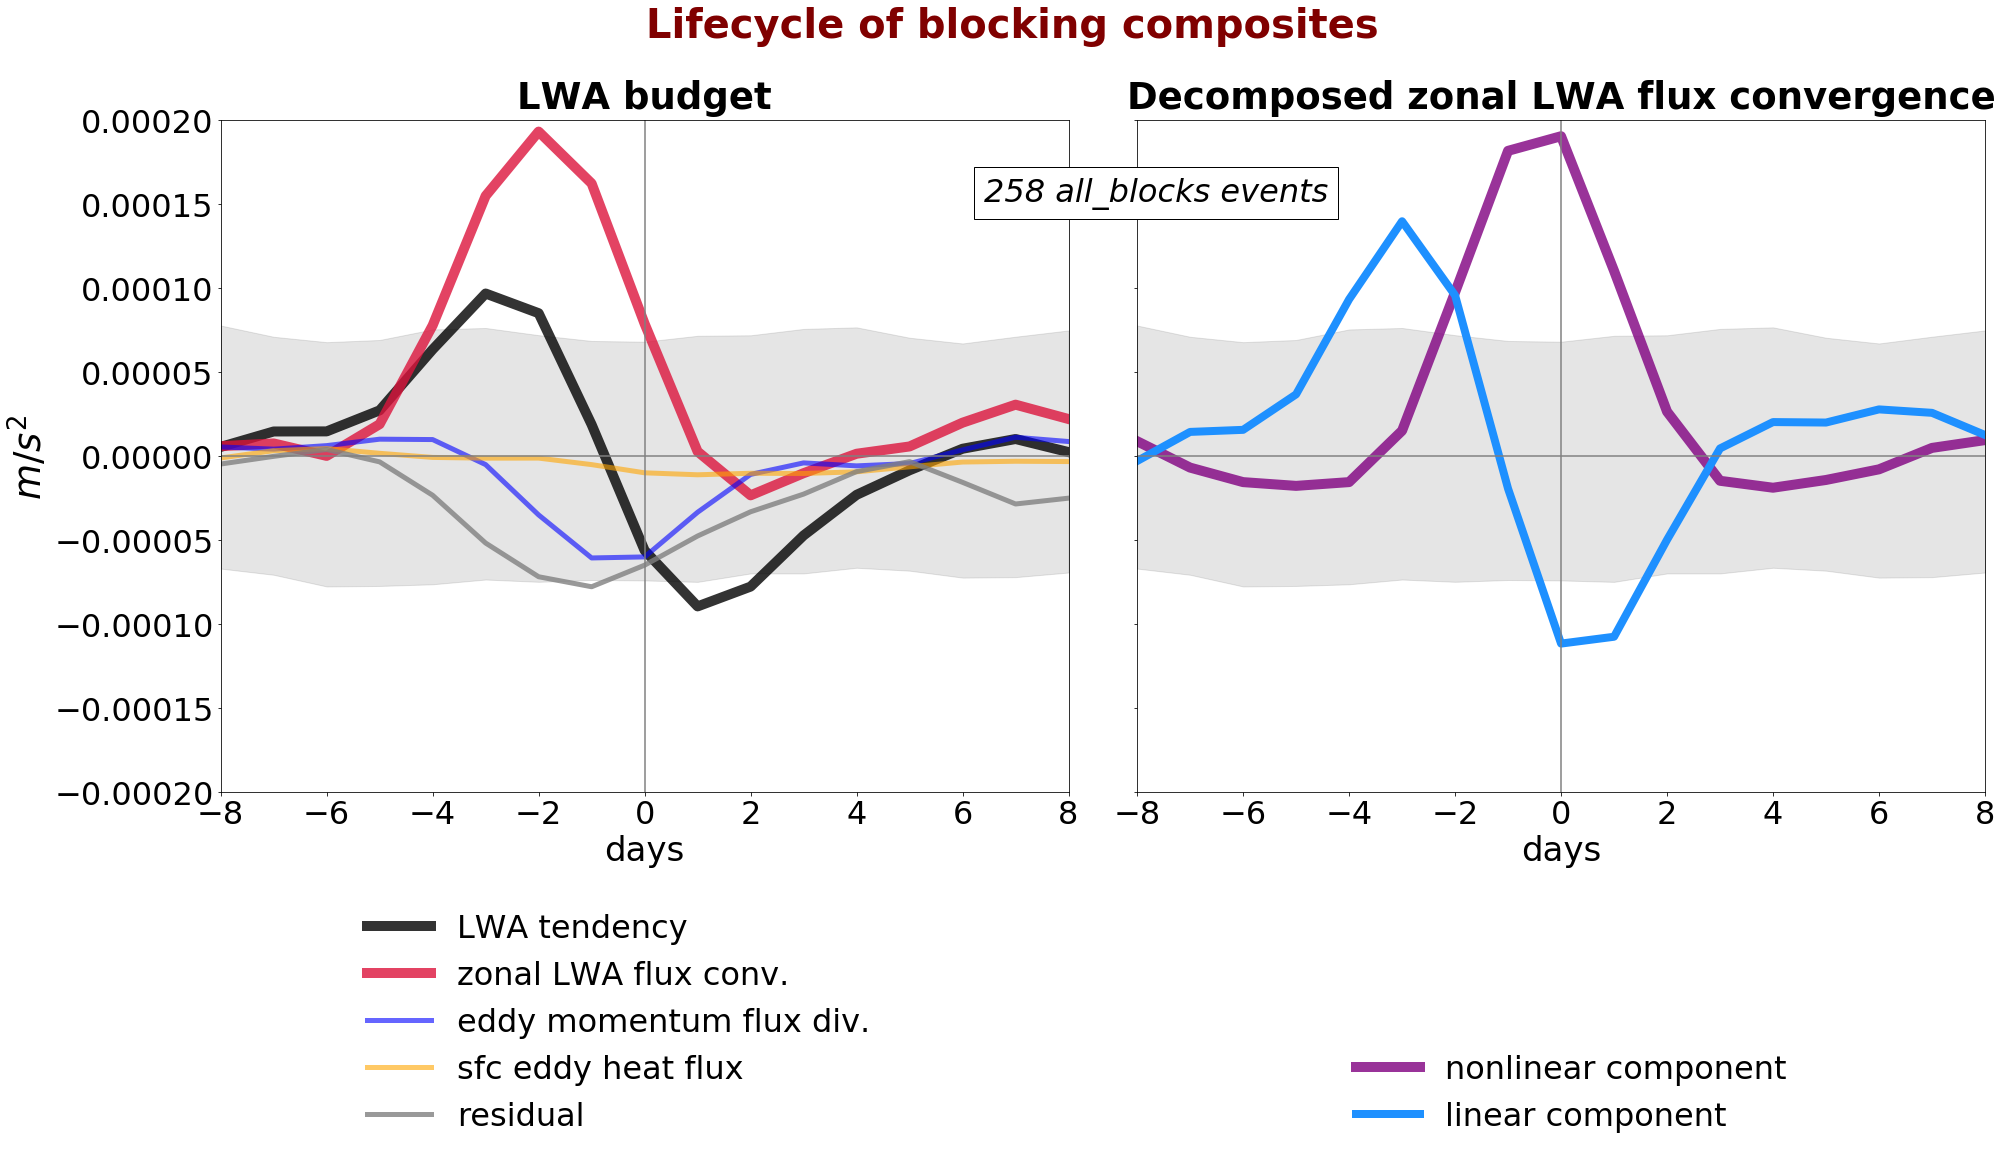

In [211]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Atlantic sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))       
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')



Text(0, 0.5, '$m/s^2$')

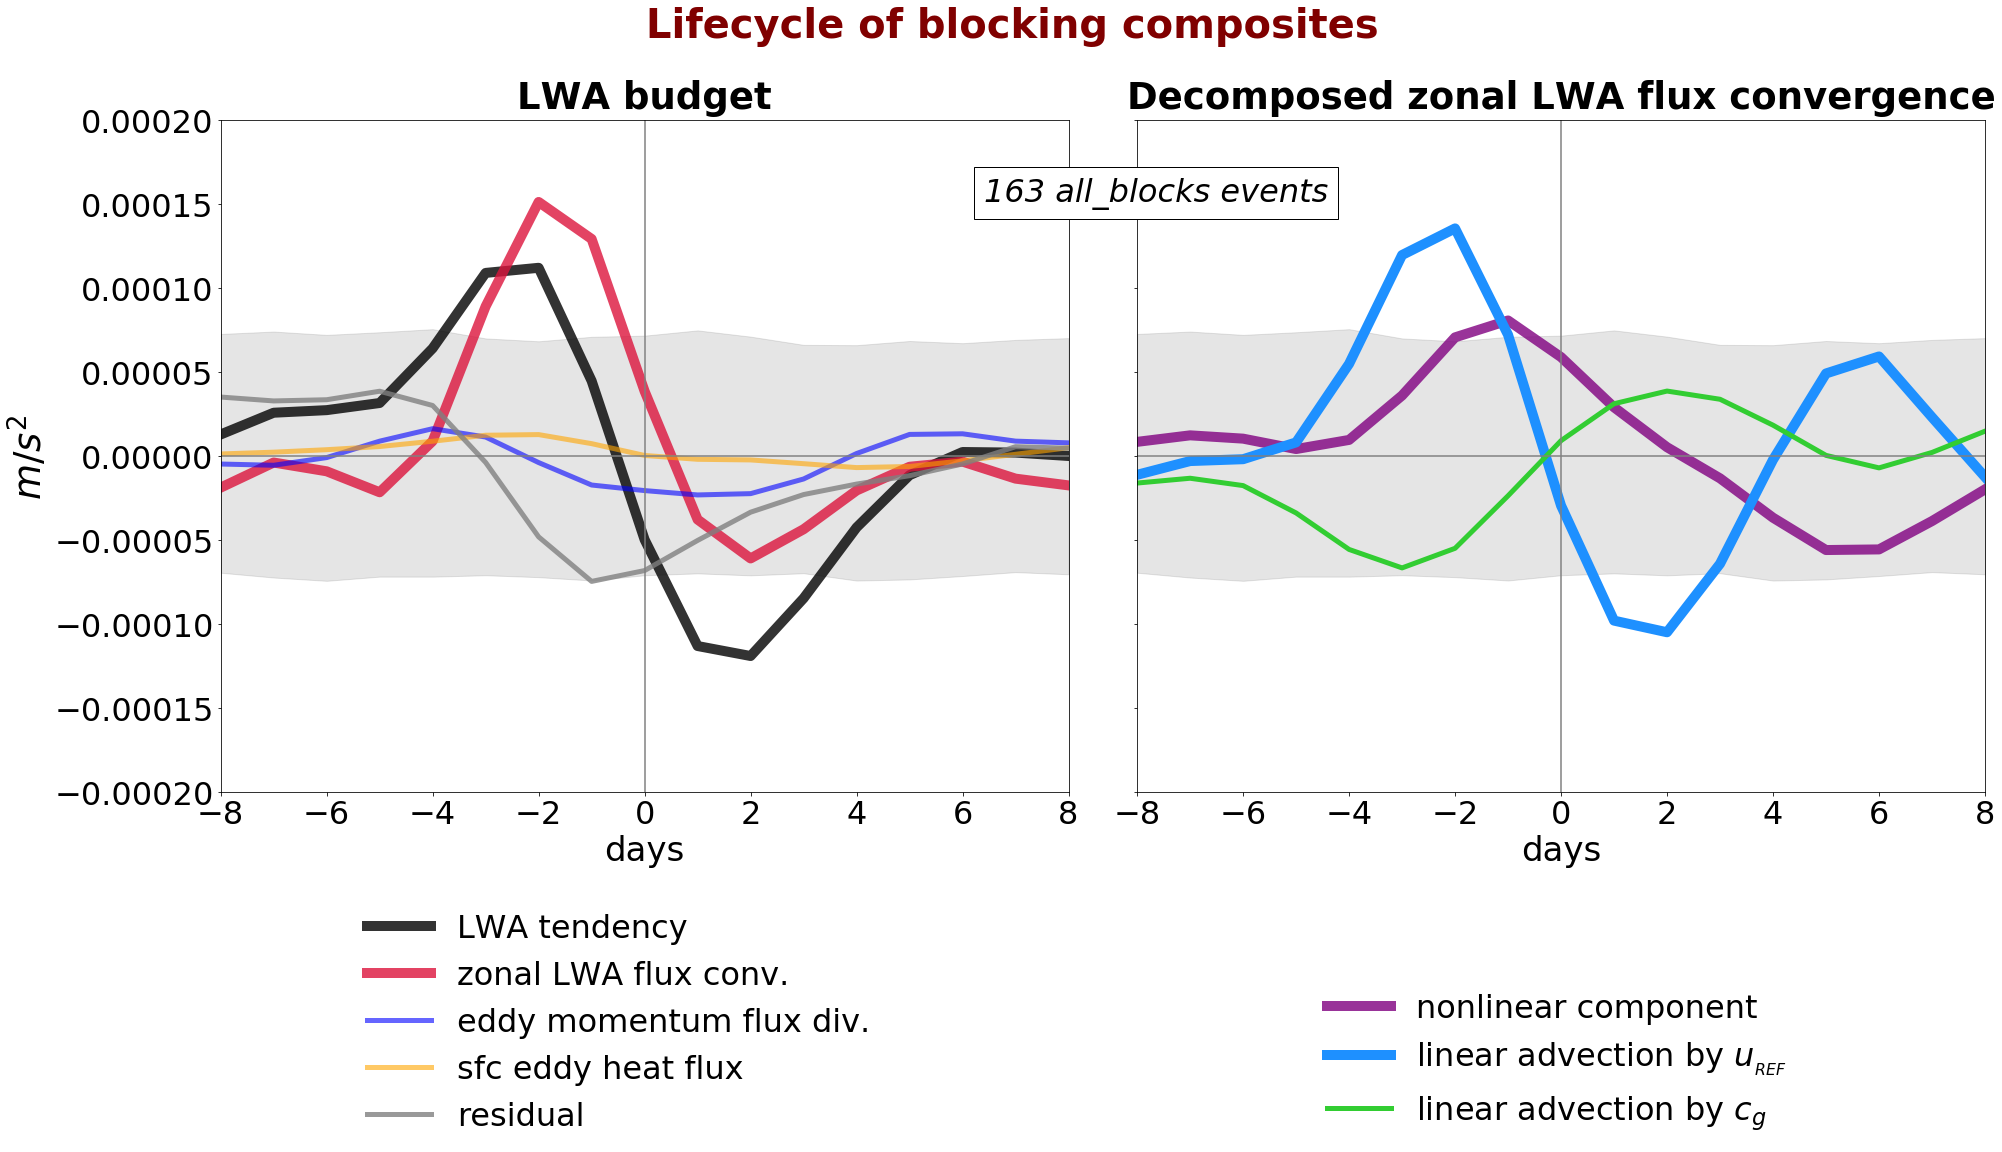

In [182]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Pacific sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))       
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')




In [212]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['North Pacific sector']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='all_blocks', YLIM=0.00020, \
                                         total_data_dictionary=all_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))       
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.07, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE+5)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')




Text(0, 0.5, '$m/s^2$')

## LWA based blocks division

Text(0, 0.5, '$m/s^2$')

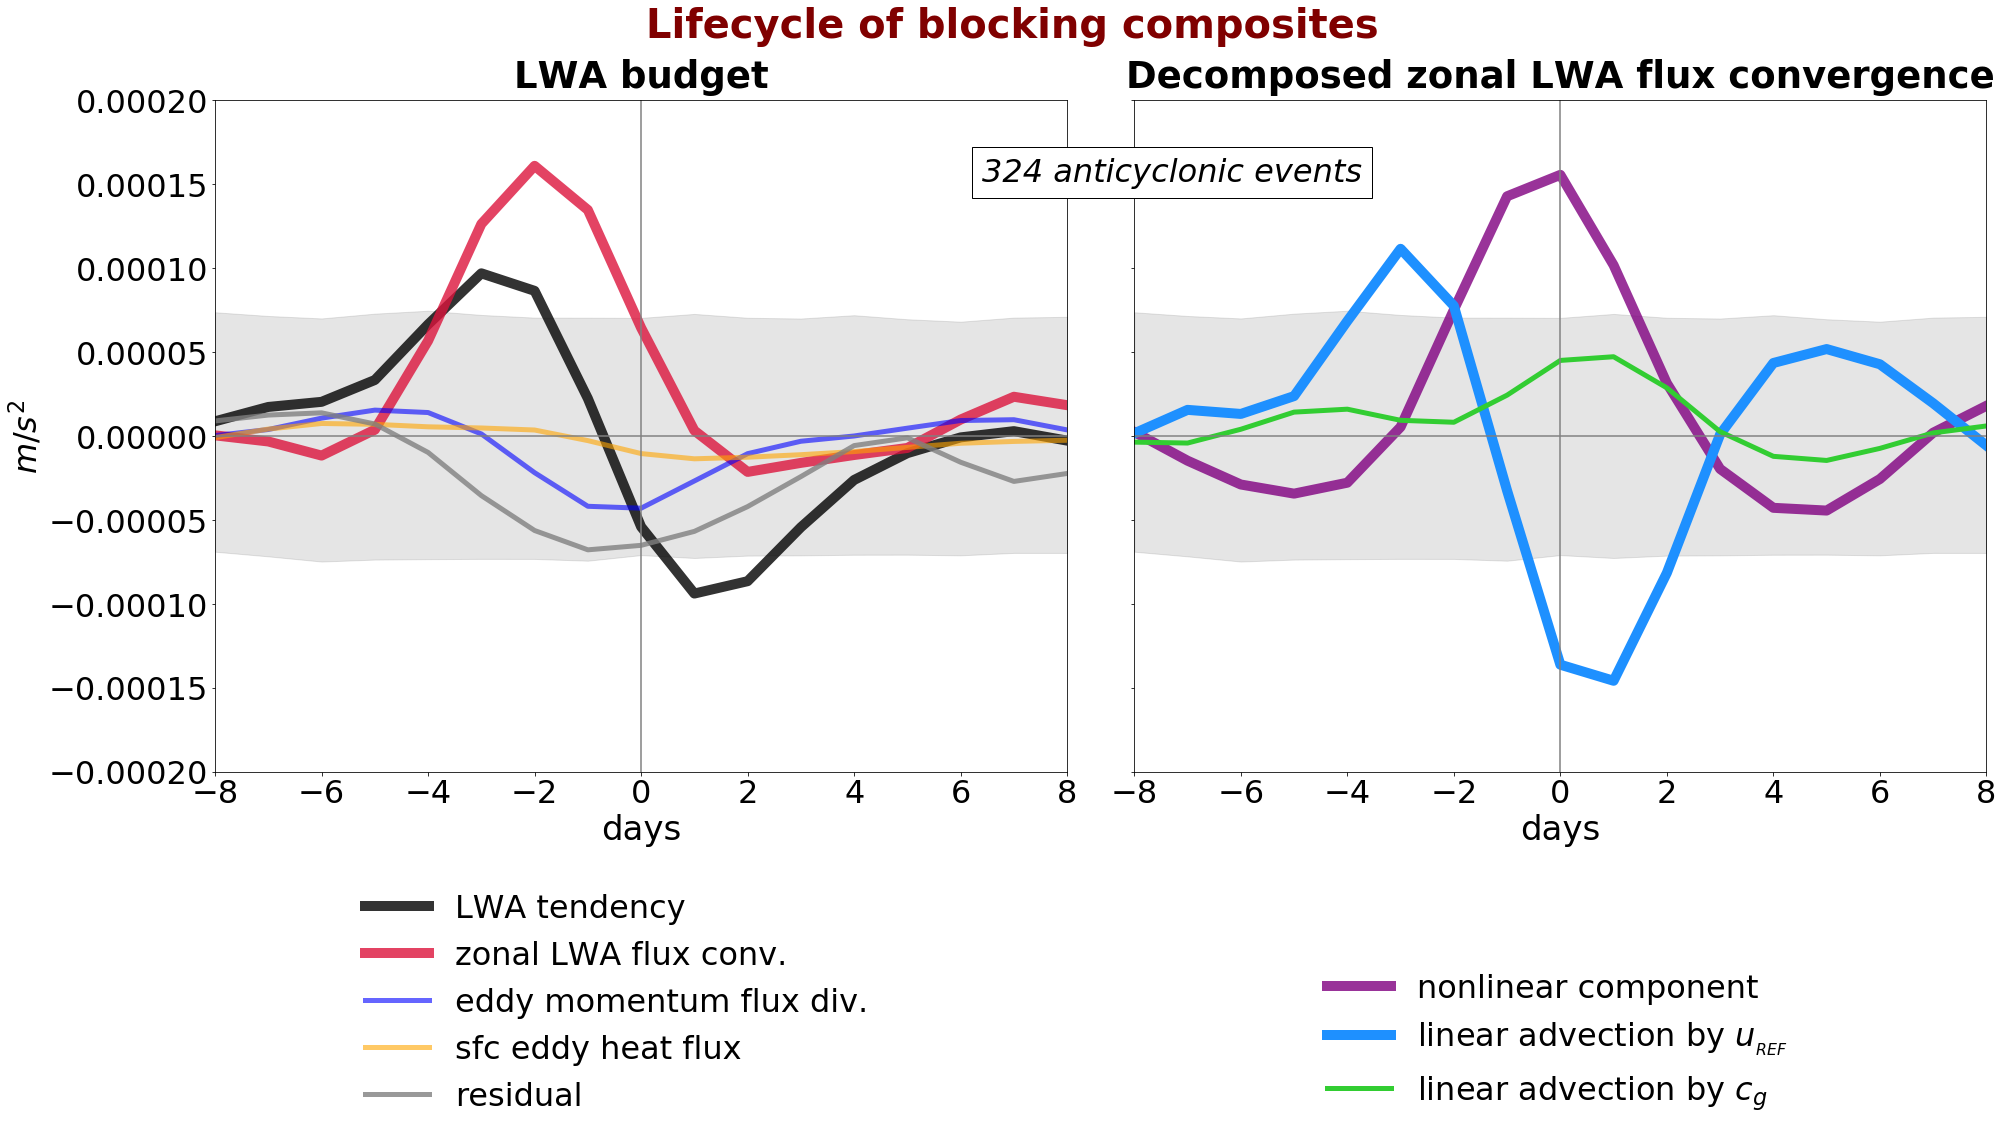

In [183]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):     
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


Text(0, 0.5, '$m/s^2$')

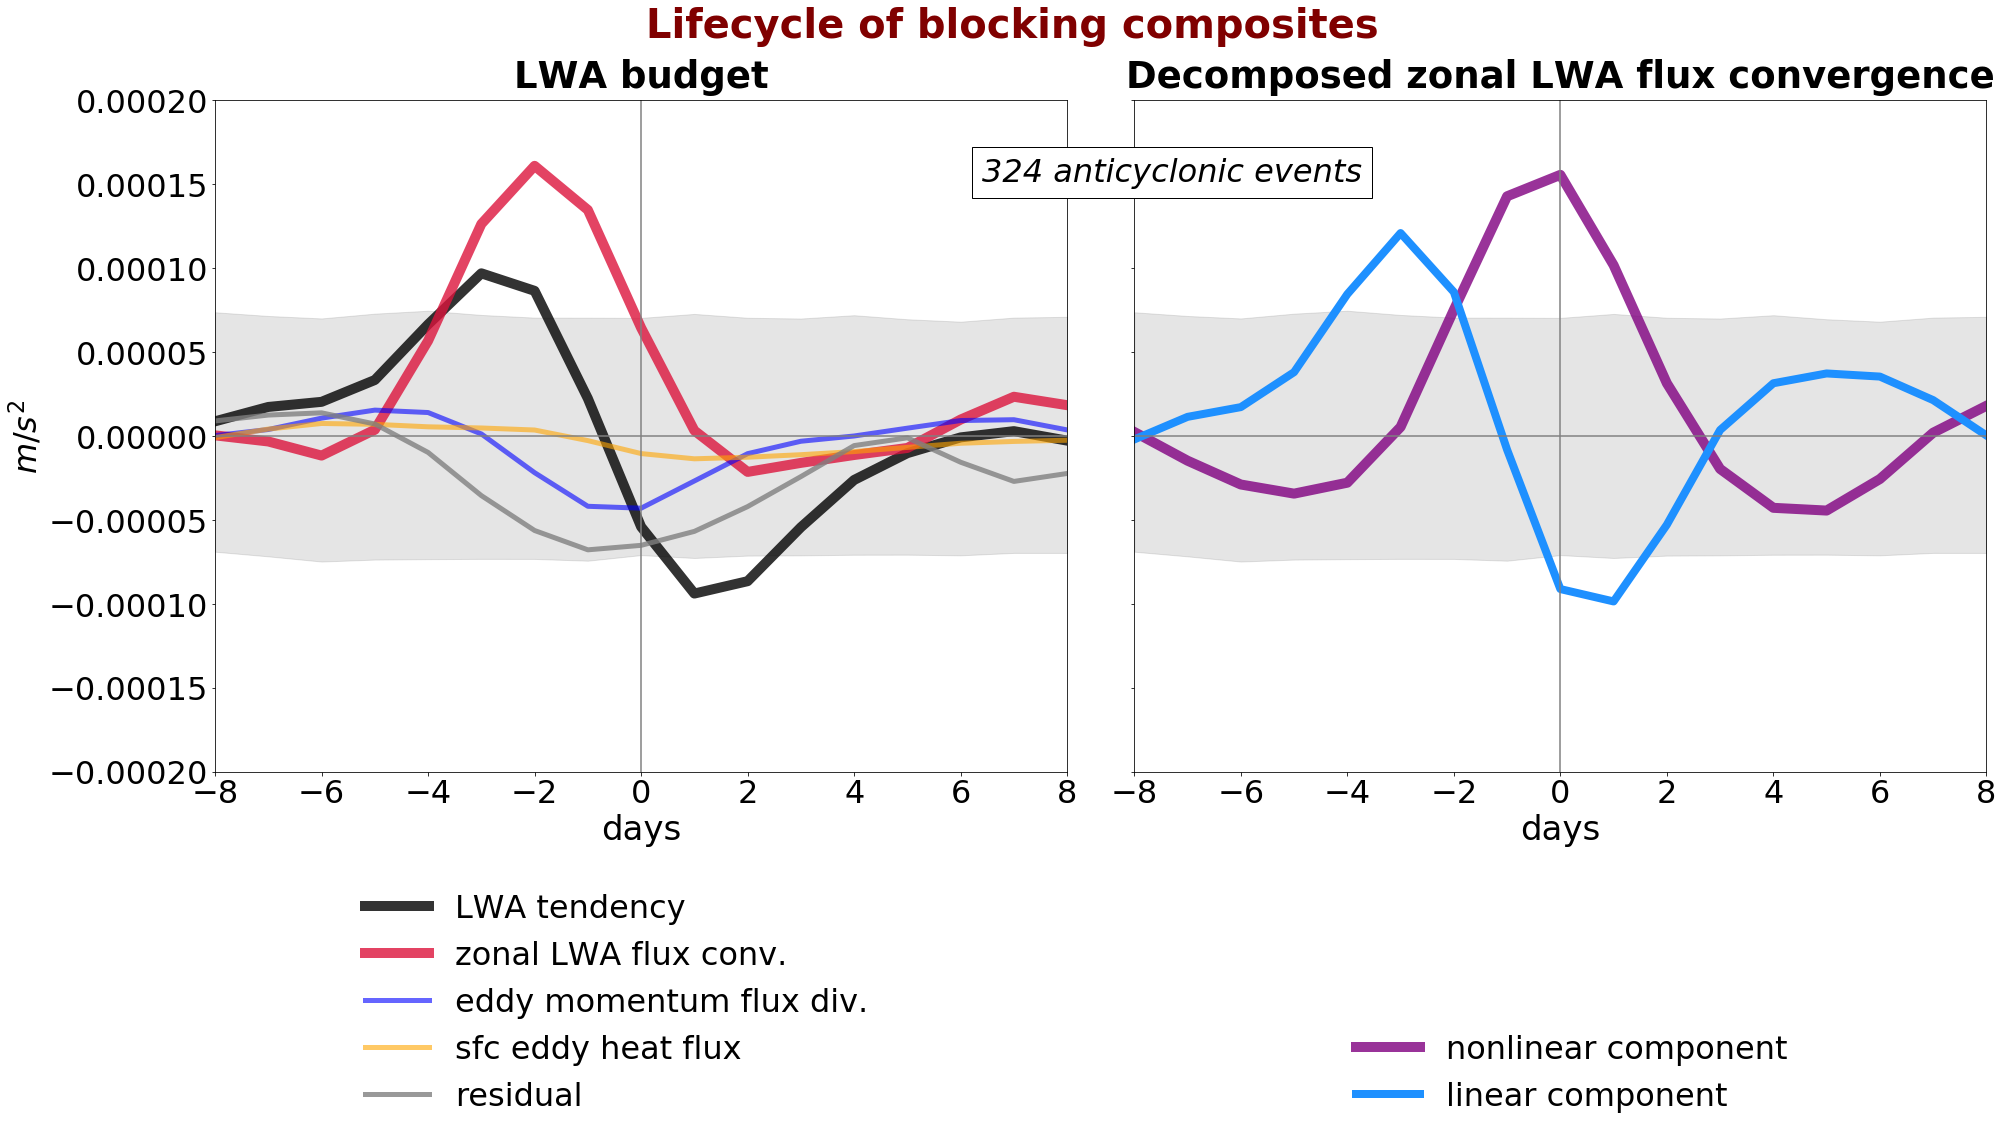

In [213]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):     
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=LWA_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


In [184]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='cyclonic', YLIM=0.00022, \
                                         total_data_dictionary=LWA_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


Text(0, 0.5, '$m/s^2$')

Text(0, 0.5, '$m/s^2$')

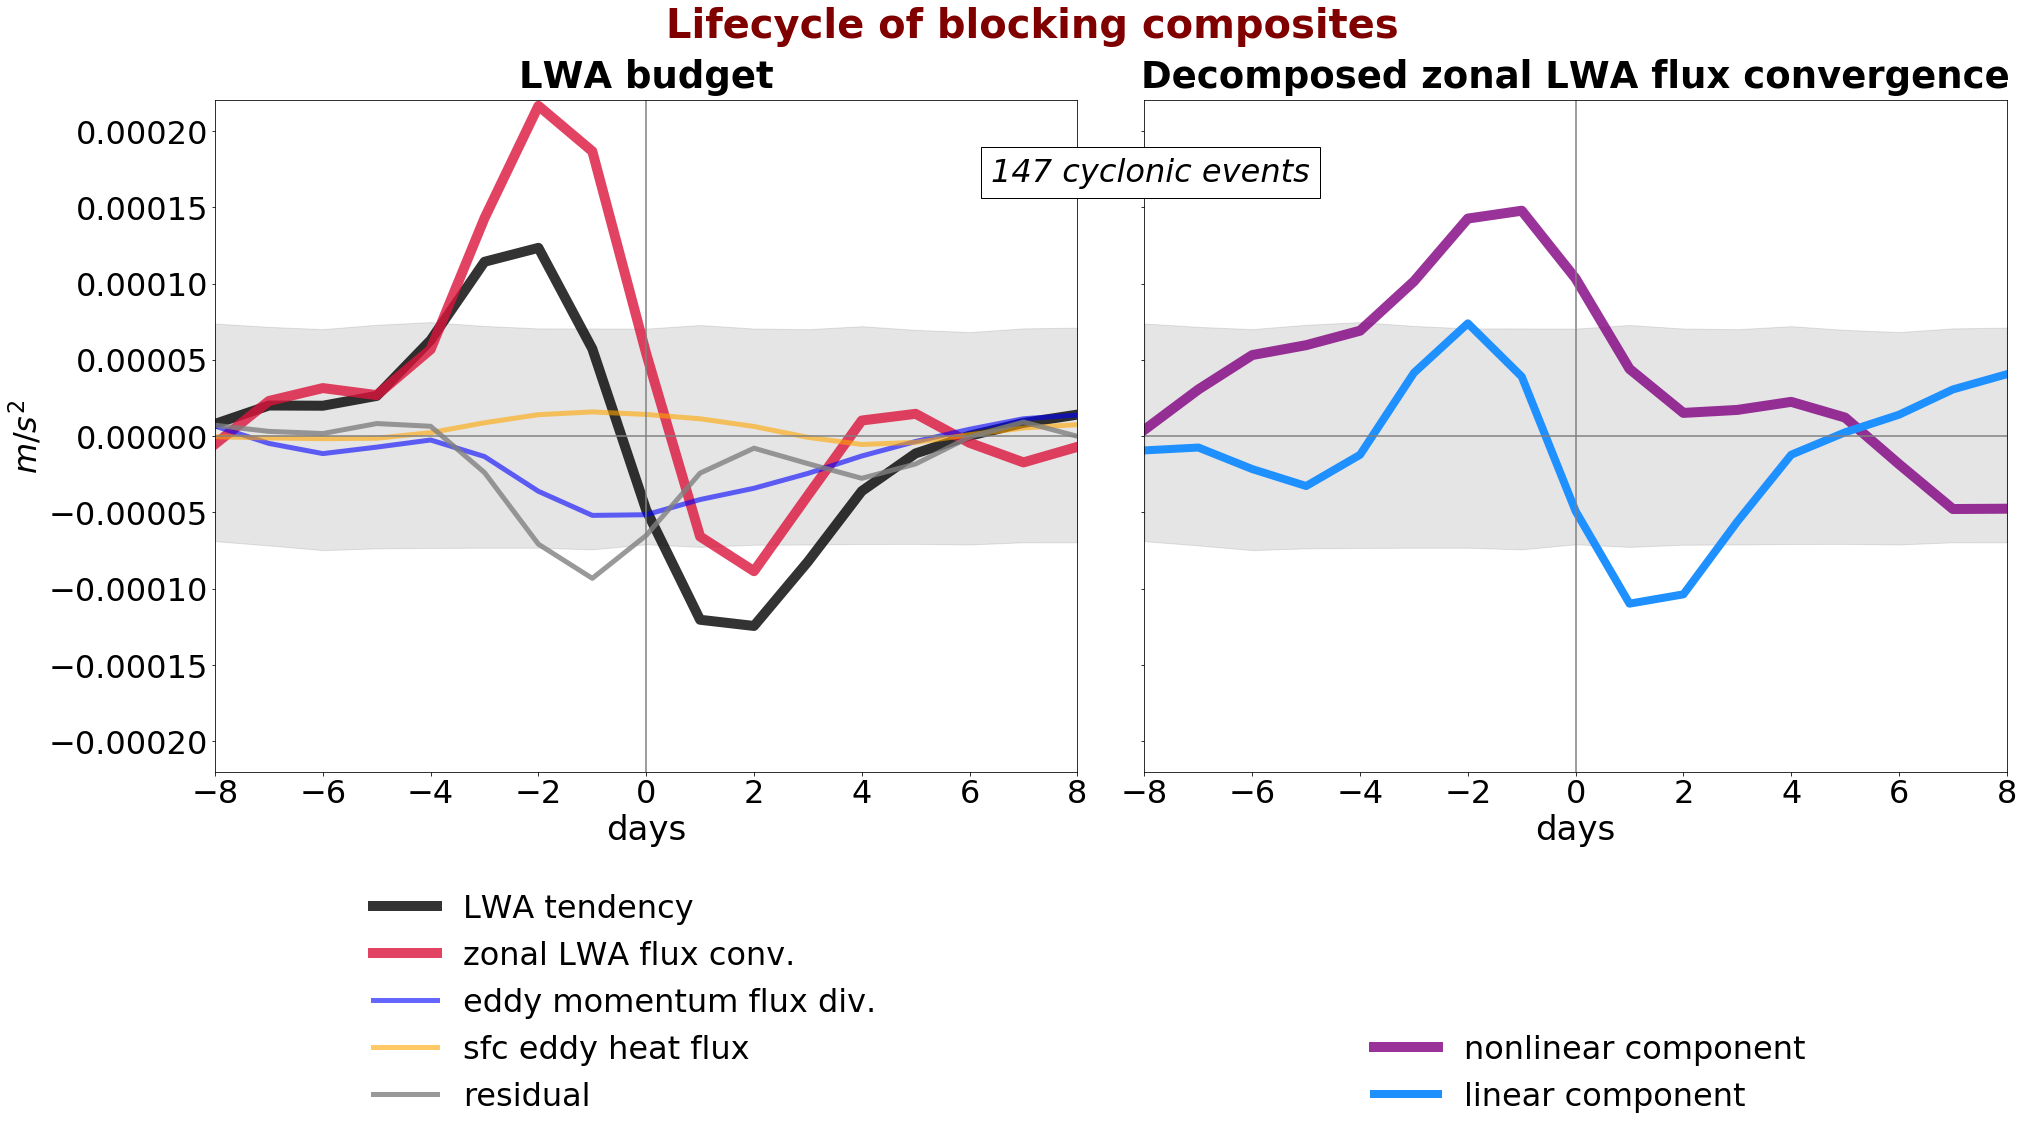

In [214]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='cyclonic', YLIM=0.00022, \
                                         total_data_dictionary=LWA_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


## Z300 based blocks division

In [185]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=Z300_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')
AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


Text(0, 0.5, '$m/s^2$')

In [215]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='anticyclonic', YLIM=0.00020, \
                                         total_data_dictionary=Z300_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')
AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


Text(0, 0.5, '$m/s^2$')

Text(0, 0.5, '$m/s^2$')

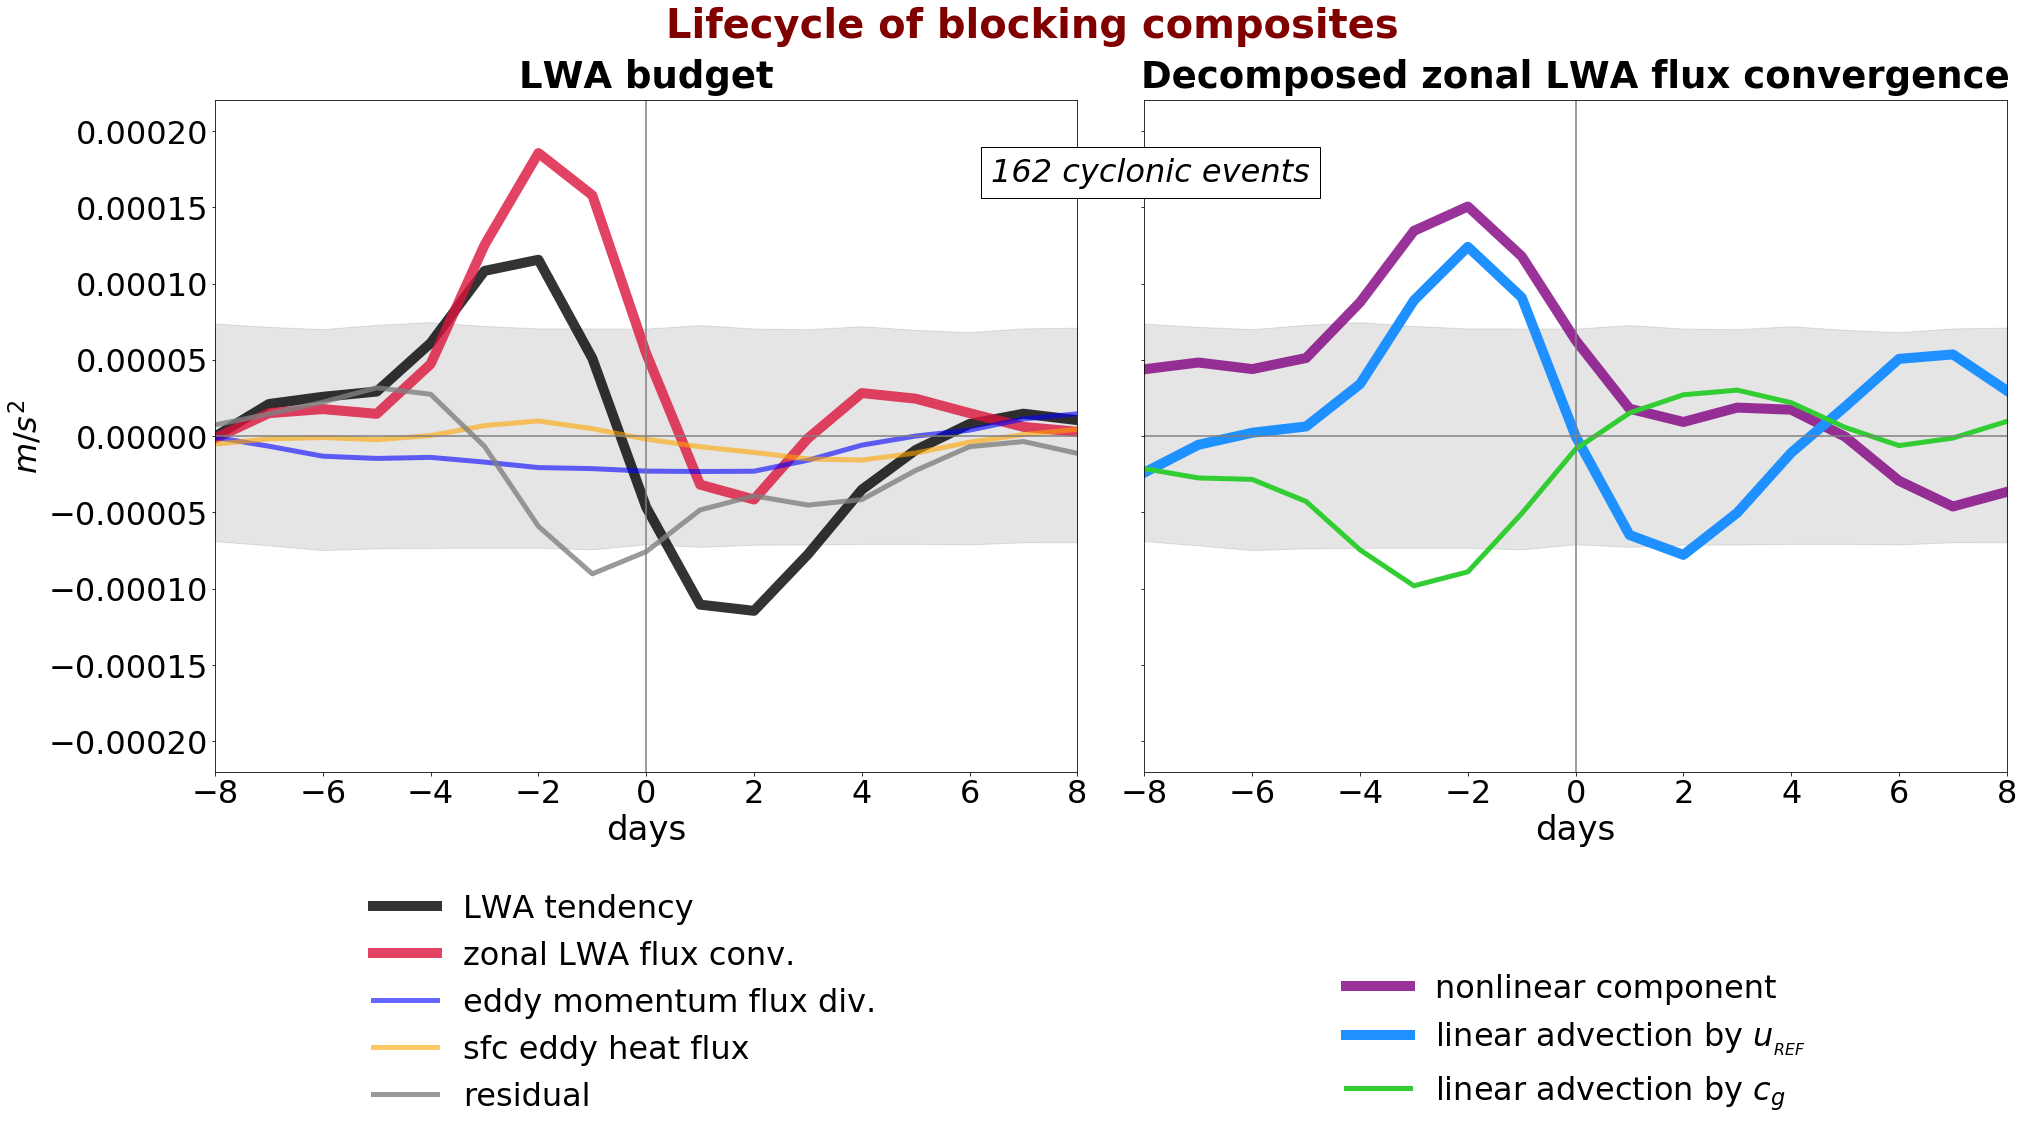

In [186]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='cyclonic', YLIM=0.00022, \
                                         total_data_dictionary=Z300_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')


Text(0, 0.5, '$m/s^2$')

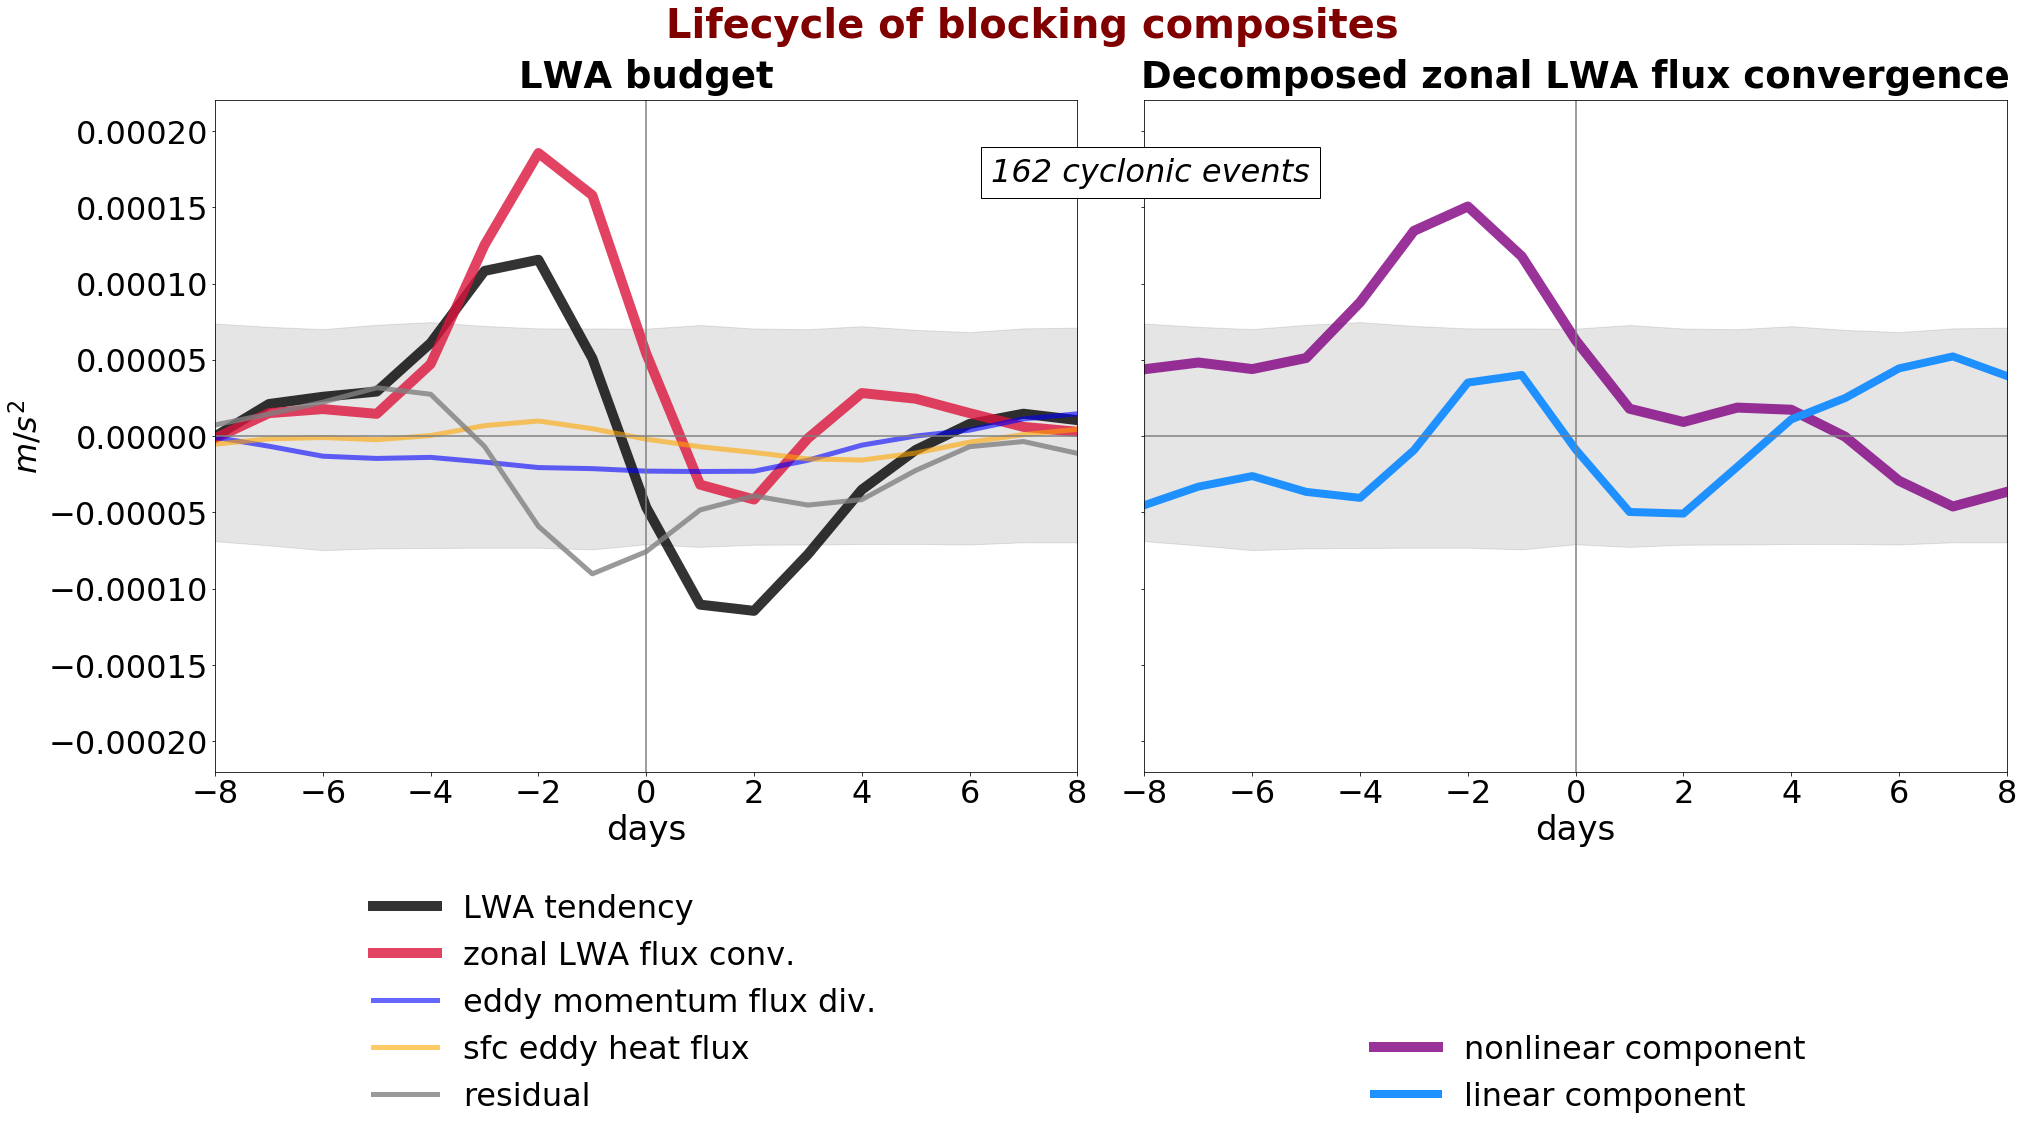

In [216]:
fig, axs = py.subplots(1, 2, figsize=(28,14), constrained_layout=True,  sharey=True)

FONTSIZE = 32

for N, region_name in enumerate(['Global composites']):    
    regions = REGIONS_VARIABLE_NAMES[region_name]
    plot_lifecycle_for_different_regions(N=0, regions = regions, region_name=region_name, days=np.arange(4,18,1), \
                                         FONTSIZE=FONTSIZE, axs=axs, fig=fig, block_type='cyclonic', YLIM=0.00022, \
                                         total_data_dictionary=Z300_blocks_dictionary, CI=[15, 85], bbox_to_anchor=(0.8, -0.55))    
fig.suptitle('Lifecycle of blocking composites', fontsize=FONTSIZE+8, color='maroon', y=1.05, fontweight='bold')

AX = axs[0]
AX.set_ylabel(r'$m/s^2$', fontsize=FONTSIZE)
    
# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Budget_lifecycle_global_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Budget_lifecycle_global_all.pdf', bbox_inches='tight')
